In [1]:
%load_ext autoreload
%autoreload 2
from dds.configs.config import set_task, get_config
from dds.train_dds import train_dds
import numpy as onp
import jax

import distrax
import jax.numpy as jnp
import haiku as hk
from jaxline import utils

import functools
import timeit
from typing import Any, List, Tuple, Optional
from absl import app, flags

from absl import logging
import haiku as hk
import distrax
import jax
import jax.numpy as jnp

from ml_collections import config_dict as configdict
from ml_collections import config_flags

import numpy as onp
import optax

from jaxline import utils

from dds.configs.config import set_task
from dds.data_paths import results_path
from dds.utils import flatten_nested_dict
import wandb
print(jax.devices())

2023-08-17 20:07:53.072957: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-08-17 20:07:53.073056: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-08-17 20:07:53.073067: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)]


In [2]:
from dds.objectives import controlled_ais_relative_kl_objective
from dds.objectives import controlled_ais_importance_weighted_partition_estimate_dds


config = get_config()

# Time and step settings (Need to be done before calling set_task)
config.model.tfinal = 6.4
# config.model.tfinal = 10
config.model.dt = 0.05

config.model.reference_process_key = "cais"

config.trainer.objective = controlled_ais_relative_kl_objective
config.trainer.lnz_is_estimator = controlled_ais_importance_weighted_partition_estimate_dds

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"

config = set_task(config, "ion")

if config.model.reference_process_key == "oudstl":
    config.model.step_scheme_key = "cos_sq"
    
    # Opt setting for funnel
    config.model.sigma = 1.
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False

if config.model.reference_process_key == "cais":
    config.model.step_scheme_key = "linear"
    
    # Opt setting for funnel
    config.model.alpha = 0.6875
    config.model.m = 1.0
        
    # Path opt settings    
    config.model.exp_dds = False
    config.trainer.lr_sch_base_dec = 1.0
    config.trainer.learning_rate = 1 * 10**(-5)
    
    if config.task == "funnel": # lnZ: 0.4, ELBO: 1.6
        config.model.sigma = 1.25
        config.model.sigma_base = 1.75
        config.trainer.learning_rate = 1 * 10**(-5)
        config.trainer.lr_sch_base_dec = 0.95 # For funnel
        
    if config.task == "lr_sonar": # lnZ: -109.1, ELBO: -114.76
        config.model.sigma = 0.5
        config.model.sigma_base = 0.6
    
    if config.task == "ion":     # lnZ: -112.275, ELBO: -117.619
        config.model.sigma = 0.5
        config.model.sigma_base = 0.7
    
    if config.task == "lgcp":  # lnZ: 473, ELBO: 413
        config.model.sigma = 4.6
        config.model.sigma_base = 2.3
    


config.model.stl = False
config.model.detach_stl_drift = False

config.trainer.notebook = True
config.trainer.epochs = 200  #  11000
# Opt settings we use
# funnel_config.trainer.learning_rate = 0.0001
# config.trainer.learning_rate = 5 * 10**(-3)

config.model.reference_process_key = "cais"
# config.trainer.learning_rate = 0
config.trainer.epochs = 11000
# config.trainer.epochs = 1
config.model.sigma, config.model.sigma_base

(0.5, 0.7)

In [3]:
config.trainer.epochs

11000

In [4]:
def update_detached_params(trainable_params, non_trainable_params,
                           attached_network_name="simple_drift_net",
                           detached_network_name="stl_detach"):
  """Auxiliary function updating detached params for STL.

  Args:
      trainable_params:
      non_trainable_params:
      attached_network_name:
      detached_network_name:
  Returns:
    Returns non trainable params
  """

  if len(trainable_params) != len(non_trainable_params):
    return non_trainable_params

  for key in trainable_params.keys():
    if attached_network_name in key:
      key_det = key.replace(attached_network_name, detached_network_name)
    else:
      key_det = key.replace("diffusion_network",
                            detached_network_name + "_diff")
    non_trainable_params[key_det] = trainable_params[key]  # pytype: disable=unsupported-operands

  return non_trainable_params

data_dim = config.model.input_dim
device_no = jax.device_count()

results_path = '~/denoising_diffusion_samplers/results'
alpha = config.model.alpha
sigma = config.model.sigma
m = config.model.m

if config.model.reference_process_key == "oudstl":
    config.model.sigma_base = config.model.sigma

# post setup model vars
config.model.source_obj = distrax.MultivariateNormalDiag(
    jnp.zeros(config.model.input_dim),
    config.model.sigma_base * jnp.ones(config.model.input_dim))
config.model.source = config.model.source_obj.log_prob

batch_size_ = int(config.model.batch_size / device_no)
batch_size_elbo = int(config.model.elbo_batch_size / device_no)

step_scheme = config.model.step_scheme_dict[config.model.step_scheme_key]

dt = config.model.dt

if config.model.reference_process_key == "oududp":
    key_conversion = {
        "pis": "pisudp",
        "vanilla": "vanilla_udp",
        "tmpis": "tmpis_udp"
    }
    # "pisudp"
    config.model.network_key = key_conversion[config.model.network_key]

net_key = config.model.network_key
network = config.model.network_dict[net_key]

tpu = config.model.tpu

detach_dif_path, detach_dritf_path = (
    config.model.detach_path, config.model.detach_path)

target = config.model.target

tfinal = config.model.tfinal
lnpi = config.trainer.lnpi

ref_proc_key = config.model.reference_process_key
ref_proc = config.model.reference_process_dict[ref_proc_key]

trim = (2 if "stl" in str(ref_proc).lower() or "udp" in str(ref_proc).lower()
        else 1)

stl = config.model.stl

brown = "brown" in str(ref_proc).lower()

seed = config.trainer.random_seed  if "random_seed" in config.trainer else 42

# task directory (currently not in use)
task = config.task
method = config.model.reference_process_key
task_path = results_path + f"/{task}" + f"/{ref_proc_key}" + f"/{net_key}"
task_path += f"/{method}"


# checkpoiting variables for wandb
nsteps = config.model.ts.shape[0]
keep_every_nth = int(config.trainer.epochs / 125)
file_name = (f"/alpha_{alpha}_sigma_{sigma}_epochs_{config.trainer.epochs}" +
            f"_task_{task}_seed_{seed}_steps_{nsteps}_stl_{stl}_{method}" +
            f"_scheme_{config.model.step_scheme_key}_ddpm_test11_chk")
_ = task_path + file_name

detach_stl_drift = (
    config.model.detach_stl_drift if
    "detach_stl_drift" in config.model else False
)

drift_network = lambda: network(config.model, data_dim, "simple_drift_net")

############## wandb logging  place holder ################
data_id = "denoising_diffusion_samplers"  # Project name

In [5]:
from turtle import forward


def _forward_fn(batch_size: int,
                training: bool = True,
                ode=False, exact=False, dt_=dt) -> jnp.ndarray:

    model_def = ref_proc(
        sigma, 
        data_dim, 
        drift_network, 
        tfinal=tfinal, 
        dt=dt_,
        step_scheme=step_scheme, 
        alpha=alpha, 
        target=target, 
        tpu=tpu,
        detach_stl_drift=detach_stl_drift, 
        diff_net=None,
        detach_dritf_path=detach_dritf_path, 
        detach_dif_path=detach_dif_path,
        m=m, 
        log=config.model.log, 
        exp_bool=config.model.exp_dds, 
        exact=exact
    )

    return model_def(batch_size, training, ode=ode)

forward_fn = hk.transform_with_state(_forward_fn)  

print(forward_fn)


TransformedWithState(init=<function transform_with_state.<locals>.init_fn at 0x7f41e8542d40>, apply=<function transform_with_state.<locals>.apply_fn at 0x7f41e8542ef0>)


In [6]:
# opt and loss setup
seq = hk.PRNGSequence(seed)
rng_key = next(seq)
# subkeys = jax.random.split(rng_key, device_no)
subkeys = utils.bcast_local_devices(rng_key)

p_init = jax.pmap(
    functools.partial(forward_fn.init, batch_size=batch_size_,
                        training=True), axis_name="num_devices")

params, model_state = p_init(subkeys)

trainable_params, non_trainable_params = hk.data_structures.partition(
    lambda module, name, value: "stl_detach" not in module, params)

clipper = optax.clip(1.0)
base_dec = config.trainer.lr_sch_base_dec
scale_by_adam = optax.scale_by_adam()
# if base_dec == 0:
#   scale_by_lr = optax.scale(-config.trainer.learning_rate)
#   opt = optax.chain(clipper, scale_by_adam, scale_by_lr)
# else:
transition_steps = 50
exp_lr = optax.exponential_decay(config.trainer.learning_rate,
                                transition_steps, base_dec)
scale_lr = optax.scale_by_schedule(exp_lr)
opt = optax.chain(clipper, scale_by_adam, scale_lr, optax.scale(-1))

# opt = optax.adam(learning_rate=config.trainer.learning_rate)
opt_state = jax.pmap(opt.init)(trainable_params)

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(3, 4, 5, 6))
def forward_fn_jit(
    params,
    model_state: hk.State,
    subkeys: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False,  dt_=dt):

    samps, _ = forward_fn.apply(
        params,
        model_state,
        subkeys,
        int(batch_size / device_no),
        False,
        ode=ode, exact=exact, dt_=dt_)
    samps = jax.device_get(samps)

    augmented_trajectory, ts = samps
    return (augmented_trajectory, ts), _

def forward_fn_wrap(
    params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray, ode=False, exact=False, dt_=dt):
    subkeys = jax.random.split(rng_key, device_no)
    (augmented_trajectory, ts), _ = forward_fn_jit(params, model_state,
                                                subkeys, batch_size, ode, exact,
                                                dt_)

    dv, ns, t, _ = augmented_trajectory.shape
    augmented_trajectory = augmented_trajectory.reshape(dv*ns, t, -1)
    return (augmented_trajectory, utils.get_first(ts)), _

In [7]:
def full_objective(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    is_training: bool = True,
    ode: bool = False,
    stl: bool = False,
    exact: bool = False,
  ):

  params = hk.data_structures.merge(trainable_params, non_trainable_params)
  (augmented_trajectory, _), model_state = forward_fn.apply(
      params, model_state, rng_key, batch_size, True, ode, exact
  )

  # import pdb; pdb.set_trace()
  gpartial = functools.partial(
      config.model.terminal_cost,
      lnpi=lnpi, sigma=sigma, tfinal=tfinal, brown=brown)
  
  if is_training:
    loss = config.trainer.objective(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, stl=stl, trim=trim, dim=data_dim)
  elif not ode:
    loss = config.trainer.lnz_is_estimator(
        augmented_trajectory, gpartial, source=config.model.source, target=config.model.target, dim=data_dim)
  else:
    loss = config.trainer.lnz_pf_estimator(
        augmented_trajectory, config.model.source, config.model.target)
  return loss, model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(5,))
def update(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    opt_state: Any,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray):
  grads, new_model_state = jax.grad(
      full_objective, has_aux=True)(
          trainable_params,
          non_trainable_params,
          model_state,
          rng_key,
          batch_size,
          is_training=True,
          stl=stl)
  grads = jax.lax.pmean(grads, axis_name="num_devices")

  updates, opt_state = opt.update(grads, opt_state)
  new_params = optax.apply_updates(trainable_params, updates)
  return new_params, opt_state, new_model_state

@functools.partial(
    jax.pmap, axis_name="num_devices", static_broadcasted_argnums=(4, 5, 6, 7))
def jited_val_loss(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: jnp.ndarray,
    is_training: bool = True,
    ode: bool = False,
    exact: bool = False,):

  loss, new_model_state = full_objective(
      trainable_params,
      non_trainable_params,
      model_state,
      rng_key,
      batch_size,
      is_training=is_training, ode=ode,
      stl=False, exact=exact,)

  loss = jax.lax.pmean(loss, axis_name="num_devices")
  return loss, new_model_state

def eval_report(
    trainable_params,
    non_trainable_params,
    model_state: hk.State,
    rng_key: jnp.ndarray,
    batch_size: int,
    epoch: int,
    loss_list: List[float],
    is_training: bool = True,
    print_flag: bool = False,
    ode: bool = False,
    exact: bool = False,
    wandb_run=None,
    wandb_key: Optional[str] = None,
) -> None:

  loss, model_state = jited_val_loss(
      trainable_params, non_trainable_params,
      model_state, rng_key, batch_size, is_training, ode, exact)
  loss = jax.device_get(loss)
  loss = onp.asarray(utils.get_first(loss).item()).item()

  log_string = "epoch: %s %s  loss: %s", epoch, "TRAIN", loss
  logging.info(log_string)
  if config.trainer.notebook and print_flag: print(log_string)

  loss_list.append(loss)
  if wandb_run:
    wandb_run.log({f"{wandb_key}/epoch": epoch, f"{wandb_key}/loss": loss})
  # writer.flush()

loss_list = []
loss_list_is = []
loss_list_pf = []

start = 0
times = []

run = None

for epoch in range(start, config.trainer.epochs):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  
  if epoch == 0:
      eval_report(trainable_params, non_trainable_params,
                    model_state, subkeys, batch_size_elbo, epoch - 1,
                    loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")
  if config.trainer.epochs == 1:
    break

  trainable_params, opt_state, model_state = update(trainable_params,
                                                    non_trainable_params,
                                                    model_state, opt_state,
                                                    subkeys, batch_size_)
  if config.trainer.timer:
    def func():
      return jax.block_until_ready(
          update(trainable_params, non_trainable_params, model_state,
                opt_state, subkeys, batch_size_))

    delta_time = timeit.timeit(func, number=1)
    times.append(delta_time)

  update_detached_params(trainable_params, non_trainable_params,
                        "simple_drift_net", "stl_detach")

  if epoch % config.trainer.log_every_n_epochs == 0:

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list, print_flag=True, wandb_run=run, wandb_key="elbo_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_is, is_training=False, wandb_run=run, wandb_key="is_results")

    eval_report(trainable_params, non_trainable_params,
                model_state, subkeys, batch_size_elbo, epoch,
                loss_list_pf, is_training=False, ode=True, wandb_run=run, wandb_key="pf_results")

    lr = onp.asarray(exp_lr(epoch).item()).item()
    if run:
        run.log({"lr/epoch": epoch, "lr/lr": lr})

print("TRAINING COMPLETED")
loss_list_is_eval, loss_list_eval, loss_list_pf_eval = [], [], []
for i in range(config.eval.seeds):
  rng_key = next(seq)
  subkeys = jax.random.split(rng_key, device_no)
  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_eval,
      print_flag=True,
      wandb_run=run,
      wandb_key="elbo_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_is_eval,
      is_training=False,
      wandb_run=run,
      wandb_key="is_results_eval",)

  eval_report(
      trainable_params,
      non_trainable_params,
      model_state,
      subkeys,
      batch_size_elbo,
      i,
      loss_list_pf_eval,
      is_training=False, ode=True, exact=False,
      wandb_run=run,
      wandb_key="pf_results_eval",)

params = hk.data_structures.merge(trainable_params, non_trainable_params)
if config.trainer.timer:
  print(times[1:])

samps = 2500
if method == "lgcp" and tfinal >= 12:
  samps = 100

(augmented_trajectory, _), _ = forward_fn_wrap(params, model_state, rng_key,
                                              samps)

(augmented_trajectory_det, _), _ = forward_fn_wrap(params, model_state,
                                                  rng_key, samps, True, False)
  
(augmented_trajectory_det_ext, _), _ = forward_fn_wrap(params, model_state,
                                                      rng_key, samps, True, True)


results_dict = {
    "elbo": loss_list,
    "is": loss_list_is,
    "pf": loss_list_pf,
    "elbo_eval": loss_list_eval,
    "is_eval": loss_list_is_eval,
    "pf_eval": loss_list_pf_eval,
    "aug": augmented_trajectory,
    "aug_ode": augmented_trajectory_det,
    "aug_ode_ext": augmented_trajectory_det_ext
}

('epoch: %s %s  loss: %s', -1, 'TRAIN', 142.50814819335938)
('epoch: %s %s  loss: %s', 0, 'TRAIN', 142.40176391601562)
('epoch: %s %s  loss: %s', 1, 'TRAIN', 141.58360290527344)
('epoch: %s %s  loss: %s', 2, 'TRAIN', 142.08535766601562)
('epoch: %s %s  loss: %s', 3, 'TRAIN', 141.4271240234375)
('epoch: %s %s  loss: %s', 4, 'TRAIN', 141.775390625)
('epoch: %s %s  loss: %s', 5, 'TRAIN', 142.68565368652344)
('epoch: %s %s  loss: %s', 6, 'TRAIN', 141.73703002929688)
('epoch: %s %s  loss: %s', 7, 'TRAIN', 140.69651794433594)
('epoch: %s %s  loss: %s', 8, 'TRAIN', 141.39566040039062)
('epoch: %s %s  loss: %s', 9, 'TRAIN', 142.14390563964844)
('epoch: %s %s  loss: %s', 10, 'TRAIN', 141.0818328857422)
('epoch: %s %s  loss: %s', 11, 'TRAIN', 140.75)
('epoch: %s %s  loss: %s', 12, 'TRAIN', 141.42437744140625)
('epoch: %s %s  loss: %s', 13, 'TRAIN', 141.00558471679688)
('epoch: %s %s  loss: %s', 14, 'TRAIN', 140.59632873535156)
('epoch: %s %s  loss: %s', 15, 'TRAIN', 140.43038940429688)
('epoch: 

('epoch: %s %s  loss: %s', 137, 'TRAIN', 130.90968322753906)
('epoch: %s %s  loss: %s', 138, 'TRAIN', 131.74693298339844)
('epoch: %s %s  loss: %s', 139, 'TRAIN', 130.72476196289062)
('epoch: %s %s  loss: %s', 140, 'TRAIN', 129.307861328125)
('epoch: %s %s  loss: %s', 141, 'TRAIN', 130.014404296875)
('epoch: %s %s  loss: %s', 142, 'TRAIN', 129.8878631591797)
('epoch: %s %s  loss: %s', 143, 'TRAIN', 130.1531524658203)
('epoch: %s %s  loss: %s', 144, 'TRAIN', 130.05014038085938)
('epoch: %s %s  loss: %s', 145, 'TRAIN', 130.55923461914062)
('epoch: %s %s  loss: %s', 146, 'TRAIN', 130.026611328125)
('epoch: %s %s  loss: %s', 147, 'TRAIN', 129.3503875732422)
('epoch: %s %s  loss: %s', 148, 'TRAIN', 129.07728576660156)
('epoch: %s %s  loss: %s', 149, 'TRAIN', 129.9175262451172)
('epoch: %s %s  loss: %s', 150, 'TRAIN', 129.39242553710938)
('epoch: %s %s  loss: %s', 151, 'TRAIN', 129.31553649902344)
('epoch: %s %s  loss: %s', 152, 'TRAIN', 129.4049835205078)
('epoch: %s %s  loss: %s', 153, 'TR

('epoch: %s %s  loss: %s', 273, 'TRAIN', 125.9644546508789)
('epoch: %s %s  loss: %s', 274, 'TRAIN', 125.8878173828125)
('epoch: %s %s  loss: %s', 275, 'TRAIN', 125.76383209228516)
('epoch: %s %s  loss: %s', 276, 'TRAIN', 125.14755249023438)
('epoch: %s %s  loss: %s', 277, 'TRAIN', 125.71192932128906)
('epoch: %s %s  loss: %s', 278, 'TRAIN', 125.17039489746094)
('epoch: %s %s  loss: %s', 279, 'TRAIN', 124.8663558959961)
('epoch: %s %s  loss: %s', 280, 'TRAIN', 125.21924591064453)
('epoch: %s %s  loss: %s', 281, 'TRAIN', 125.46226501464844)
('epoch: %s %s  loss: %s', 282, 'TRAIN', 124.97830963134766)
('epoch: %s %s  loss: %s', 283, 'TRAIN', 124.7335433959961)
('epoch: %s %s  loss: %s', 284, 'TRAIN', 124.21963500976562)
('epoch: %s %s  loss: %s', 285, 'TRAIN', 125.7698974609375)
('epoch: %s %s  loss: %s', 286, 'TRAIN', 125.07373046875)
('epoch: %s %s  loss: %s', 287, 'TRAIN', 125.39777374267578)
('epoch: %s %s  loss: %s', 288, 'TRAIN', 126.13687896728516)
('epoch: %s %s  loss: %s', 289, 

('epoch: %s %s  loss: %s', 409, 'TRAIN', 122.95984649658203)
('epoch: %s %s  loss: %s', 410, 'TRAIN', 123.51370239257812)
('epoch: %s %s  loss: %s', 411, 'TRAIN', 122.84471893310547)
('epoch: %s %s  loss: %s', 412, 'TRAIN', 122.93323516845703)
('epoch: %s %s  loss: %s', 413, 'TRAIN', 123.07234954833984)
('epoch: %s %s  loss: %s', 414, 'TRAIN', 123.1457748413086)
('epoch: %s %s  loss: %s', 415, 'TRAIN', 123.4362564086914)
('epoch: %s %s  loss: %s', 416, 'TRAIN', 123.90237426757812)
('epoch: %s %s  loss: %s', 417, 'TRAIN', 122.841796875)
('epoch: %s %s  loss: %s', 418, 'TRAIN', 122.955810546875)
('epoch: %s %s  loss: %s', 419, 'TRAIN', 123.1644058227539)
('epoch: %s %s  loss: %s', 420, 'TRAIN', 122.41682434082031)
('epoch: %s %s  loss: %s', 421, 'TRAIN', 123.23056030273438)
('epoch: %s %s  loss: %s', 422, 'TRAIN', 122.27422332763672)
('epoch: %s %s  loss: %s', 423, 'TRAIN', 122.9993896484375)
('epoch: %s %s  loss: %s', 424, 'TRAIN', 123.33592987060547)
('epoch: %s %s  loss: %s', 425, 'TR

('epoch: %s %s  loss: %s', 546, 'TRAIN', 121.93980407714844)
('epoch: %s %s  loss: %s', 547, 'TRAIN', 121.10482025146484)
('epoch: %s %s  loss: %s', 548, 'TRAIN', 121.52859497070312)
('epoch: %s %s  loss: %s', 549, 'TRAIN', 121.39323425292969)
('epoch: %s %s  loss: %s', 550, 'TRAIN', 121.25843811035156)
('epoch: %s %s  loss: %s', 551, 'TRAIN', 121.64334869384766)
('epoch: %s %s  loss: %s', 552, 'TRAIN', 121.533935546875)
('epoch: %s %s  loss: %s', 553, 'TRAIN', 121.3425064086914)
('epoch: %s %s  loss: %s', 554, 'TRAIN', 121.01873016357422)
('epoch: %s %s  loss: %s', 555, 'TRAIN', 121.61453247070312)
('epoch: %s %s  loss: %s', 556, 'TRAIN', 121.52437591552734)
('epoch: %s %s  loss: %s', 557, 'TRAIN', 121.72003936767578)
('epoch: %s %s  loss: %s', 558, 'TRAIN', 121.2409896850586)
('epoch: %s %s  loss: %s', 559, 'TRAIN', 121.92750549316406)
('epoch: %s %s  loss: %s', 560, 'TRAIN', 120.87853240966797)
('epoch: %s %s  loss: %s', 561, 'TRAIN', 121.50428771972656)
('epoch: %s %s  loss: %s', 5

('epoch: %s %s  loss: %s', 683, 'TRAIN', 120.20079803466797)
('epoch: %s %s  loss: %s', 684, 'TRAIN', 120.0796890258789)
('epoch: %s %s  loss: %s', 685, 'TRAIN', 120.95890808105469)
('epoch: %s %s  loss: %s', 686, 'TRAIN', 121.15276336669922)
('epoch: %s %s  loss: %s', 687, 'TRAIN', 120.9171371459961)
('epoch: %s %s  loss: %s', 688, 'TRAIN', 120.3745346069336)
('epoch: %s %s  loss: %s', 689, 'TRAIN', 120.8156967163086)
('epoch: %s %s  loss: %s', 690, 'TRAIN', 120.46021270751953)
('epoch: %s %s  loss: %s', 691, 'TRAIN', 120.20465087890625)
('epoch: %s %s  loss: %s', 692, 'TRAIN', 119.92074584960938)
('epoch: %s %s  loss: %s', 693, 'TRAIN', 120.19187927246094)
('epoch: %s %s  loss: %s', 694, 'TRAIN', 120.63691711425781)
('epoch: %s %s  loss: %s', 695, 'TRAIN', 120.28760528564453)
('epoch: %s %s  loss: %s', 696, 'TRAIN', 120.08526611328125)
('epoch: %s %s  loss: %s', 697, 'TRAIN', 120.95276641845703)
('epoch: %s %s  loss: %s', 698, 'TRAIN', 120.67677307128906)
('epoch: %s %s  loss: %s', 6

('epoch: %s %s  loss: %s', 820, 'TRAIN', 120.10517120361328)
('epoch: %s %s  loss: %s', 821, 'TRAIN', 119.88838958740234)
('epoch: %s %s  loss: %s', 822, 'TRAIN', 119.9456558227539)
('epoch: %s %s  loss: %s', 823, 'TRAIN', 120.12687683105469)
('epoch: %s %s  loss: %s', 824, 'TRAIN', 119.95612335205078)
('epoch: %s %s  loss: %s', 825, 'TRAIN', 119.5864486694336)
('epoch: %s %s  loss: %s', 826, 'TRAIN', 120.38743591308594)
('epoch: %s %s  loss: %s', 827, 'TRAIN', 119.89053344726562)
('epoch: %s %s  loss: %s', 828, 'TRAIN', 120.3058090209961)
('epoch: %s %s  loss: %s', 829, 'TRAIN', 119.59125518798828)
('epoch: %s %s  loss: %s', 830, 'TRAIN', 120.96859741210938)
('epoch: %s %s  loss: %s', 831, 'TRAIN', 119.91778564453125)
('epoch: %s %s  loss: %s', 832, 'TRAIN', 119.28362274169922)
('epoch: %s %s  loss: %s', 833, 'TRAIN', 119.81372833251953)
('epoch: %s %s  loss: %s', 834, 'TRAIN', 119.5954360961914)
('epoch: %s %s  loss: %s', 835, 'TRAIN', 120.29705810546875)
('epoch: %s %s  loss: %s', 8

('epoch: %s %s  loss: %s', 957, 'TRAIN', 119.95297241210938)
('epoch: %s %s  loss: %s', 958, 'TRAIN', 120.0008773803711)
('epoch: %s %s  loss: %s', 959, 'TRAIN', 119.63728332519531)
('epoch: %s %s  loss: %s', 960, 'TRAIN', 119.95159149169922)
('epoch: %s %s  loss: %s', 961, 'TRAIN', 120.1300048828125)
('epoch: %s %s  loss: %s', 962, 'TRAIN', 119.819091796875)
('epoch: %s %s  loss: %s', 963, 'TRAIN', 120.26333618164062)
('epoch: %s %s  loss: %s', 964, 'TRAIN', 119.87669372558594)
('epoch: %s %s  loss: %s', 965, 'TRAIN', 119.9350814819336)
('epoch: %s %s  loss: %s', 966, 'TRAIN', 120.34774017333984)
('epoch: %s %s  loss: %s', 967, 'TRAIN', 119.78768157958984)
('epoch: %s %s  loss: %s', 968, 'TRAIN', 119.41685485839844)
('epoch: %s %s  loss: %s', 969, 'TRAIN', 119.80534362792969)
('epoch: %s %s  loss: %s', 970, 'TRAIN', 119.7630386352539)
('epoch: %s %s  loss: %s', 971, 'TRAIN', 119.79926300048828)
('epoch: %s %s  loss: %s', 972, 'TRAIN', 119.71810150146484)
('epoch: %s %s  loss: %s', 973

('epoch: %s %s  loss: %s', 1092, 'TRAIN', 119.68518829345703)
('epoch: %s %s  loss: %s', 1093, 'TRAIN', 119.76937866210938)
('epoch: %s %s  loss: %s', 1094, 'TRAIN', 120.02427673339844)
('epoch: %s %s  loss: %s', 1095, 'TRAIN', 120.16006469726562)
('epoch: %s %s  loss: %s', 1096, 'TRAIN', 119.15055084228516)
('epoch: %s %s  loss: %s', 1097, 'TRAIN', 119.58065032958984)
('epoch: %s %s  loss: %s', 1098, 'TRAIN', 120.0609130859375)
('epoch: %s %s  loss: %s', 1099, 'TRAIN', 119.62208557128906)
('epoch: %s %s  loss: %s', 1100, 'TRAIN', 119.89297485351562)
('epoch: %s %s  loss: %s', 1101, 'TRAIN', 119.79570770263672)
('epoch: %s %s  loss: %s', 1102, 'TRAIN', 119.58438110351562)
('epoch: %s %s  loss: %s', 1103, 'TRAIN', 119.61738586425781)
('epoch: %s %s  loss: %s', 1104, 'TRAIN', 119.6067886352539)
('epoch: %s %s  loss: %s', 1105, 'TRAIN', 119.52544403076172)
('epoch: %s %s  loss: %s', 1106, 'TRAIN', 119.459716796875)
('epoch: %s %s  loss: %s', 1107, 'TRAIN', 119.72285461425781)
('epoch: %s 

('epoch: %s %s  loss: %s', 1226, 'TRAIN', 119.66829681396484)
('epoch: %s %s  loss: %s', 1227, 'TRAIN', 119.34052276611328)
('epoch: %s %s  loss: %s', 1228, 'TRAIN', 119.34970092773438)
('epoch: %s %s  loss: %s', 1229, 'TRAIN', 119.73505401611328)
('epoch: %s %s  loss: %s', 1230, 'TRAIN', 119.53883361816406)
('epoch: %s %s  loss: %s', 1231, 'TRAIN', 120.13375091552734)
('epoch: %s %s  loss: %s', 1232, 'TRAIN', 119.4571762084961)
('epoch: %s %s  loss: %s', 1233, 'TRAIN', 119.94046020507812)
('epoch: %s %s  loss: %s', 1234, 'TRAIN', 119.3978271484375)
('epoch: %s %s  loss: %s', 1235, 'TRAIN', 120.19700622558594)
('epoch: %s %s  loss: %s', 1236, 'TRAIN', 119.48526000976562)
('epoch: %s %s  loss: %s', 1237, 'TRAIN', 119.20732116699219)
('epoch: %s %s  loss: %s', 1238, 'TRAIN', 119.80560302734375)
('epoch: %s %s  loss: %s', 1239, 'TRAIN', 119.4171142578125)
('epoch: %s %s  loss: %s', 1240, 'TRAIN', 119.66815185546875)
('epoch: %s %s  loss: %s', 1241, 'TRAIN', 120.00550079345703)
('epoch: %s

('epoch: %s %s  loss: %s', 1359, 'TRAIN', 119.6106185913086)
('epoch: %s %s  loss: %s', 1360, 'TRAIN', 119.296630859375)
('epoch: %s %s  loss: %s', 1361, 'TRAIN', 118.93694305419922)
('epoch: %s %s  loss: %s', 1362, 'TRAIN', 119.74437713623047)
('epoch: %s %s  loss: %s', 1363, 'TRAIN', 119.77075958251953)
('epoch: %s %s  loss: %s', 1364, 'TRAIN', 119.4886245727539)
('epoch: %s %s  loss: %s', 1365, 'TRAIN', 119.17916870117188)
('epoch: %s %s  loss: %s', 1366, 'TRAIN', 119.85482025146484)
('epoch: %s %s  loss: %s', 1367, 'TRAIN', 118.9397964477539)
('epoch: %s %s  loss: %s', 1368, 'TRAIN', 119.82088470458984)
('epoch: %s %s  loss: %s', 1369, 'TRAIN', 119.51554870605469)
('epoch: %s %s  loss: %s', 1370, 'TRAIN', 119.44742584228516)
('epoch: %s %s  loss: %s', 1371, 'TRAIN', 119.99312591552734)
('epoch: %s %s  loss: %s', 1372, 'TRAIN', 119.37449645996094)
('epoch: %s %s  loss: %s', 1373, 'TRAIN', 119.54145050048828)
('epoch: %s %s  loss: %s', 1374, 'TRAIN', 119.38968658447266)
('epoch: %s %

('epoch: %s %s  loss: %s', 1492, 'TRAIN', 119.431640625)
('epoch: %s %s  loss: %s', 1493, 'TRAIN', 119.56614685058594)
('epoch: %s %s  loss: %s', 1494, 'TRAIN', 119.44379425048828)
('epoch: %s %s  loss: %s', 1495, 'TRAIN', 119.49052429199219)
('epoch: %s %s  loss: %s', 1496, 'TRAIN', 119.68242645263672)
('epoch: %s %s  loss: %s', 1497, 'TRAIN', 119.44526672363281)
('epoch: %s %s  loss: %s', 1498, 'TRAIN', 119.54948425292969)
('epoch: %s %s  loss: %s', 1499, 'TRAIN', 119.62387084960938)
('epoch: %s %s  loss: %s', 1500, 'TRAIN', 119.23104095458984)
('epoch: %s %s  loss: %s', 1501, 'TRAIN', 119.59658813476562)
('epoch: %s %s  loss: %s', 1502, 'TRAIN', 119.52534484863281)
('epoch: %s %s  loss: %s', 1503, 'TRAIN', 119.5677490234375)
('epoch: %s %s  loss: %s', 1504, 'TRAIN', 118.947998046875)
('epoch: %s %s  loss: %s', 1505, 'TRAIN', 119.4337158203125)
('epoch: %s %s  loss: %s', 1506, 'TRAIN', 120.0171127319336)
('epoch: %s %s  loss: %s', 1507, 'TRAIN', 119.52088928222656)
('epoch: %s %s  lo

('epoch: %s %s  loss: %s', 1625, 'TRAIN', 119.45604705810547)
('epoch: %s %s  loss: %s', 1626, 'TRAIN', 119.29727172851562)
('epoch: %s %s  loss: %s', 1627, 'TRAIN', 119.17761993408203)
('epoch: %s %s  loss: %s', 1628, 'TRAIN', 119.05059814453125)
('epoch: %s %s  loss: %s', 1629, 'TRAIN', 119.09398651123047)
('epoch: %s %s  loss: %s', 1630, 'TRAIN', 119.47830963134766)
('epoch: %s %s  loss: %s', 1631, 'TRAIN', 119.10360717773438)
('epoch: %s %s  loss: %s', 1632, 'TRAIN', 119.28377532958984)
('epoch: %s %s  loss: %s', 1633, 'TRAIN', 119.72370147705078)
('epoch: %s %s  loss: %s', 1634, 'TRAIN', 119.74560546875)
('epoch: %s %s  loss: %s', 1635, 'TRAIN', 118.87031555175781)
('epoch: %s %s  loss: %s', 1636, 'TRAIN', 118.77901458740234)
('epoch: %s %s  loss: %s', 1637, 'TRAIN', 119.40911865234375)
('epoch: %s %s  loss: %s', 1638, 'TRAIN', 119.67027282714844)
('epoch: %s %s  loss: %s', 1639, 'TRAIN', 119.26775360107422)
('epoch: %s %s  loss: %s', 1640, 'TRAIN', 119.24872589111328)
('epoch: %s

('epoch: %s %s  loss: %s', 1759, 'TRAIN', 118.99224090576172)
('epoch: %s %s  loss: %s', 1760, 'TRAIN', 119.55667114257812)
('epoch: %s %s  loss: %s', 1761, 'TRAIN', 118.88356018066406)
('epoch: %s %s  loss: %s', 1762, 'TRAIN', 119.49481964111328)
('epoch: %s %s  loss: %s', 1763, 'TRAIN', 118.98724365234375)
('epoch: %s %s  loss: %s', 1764, 'TRAIN', 119.53755187988281)
('epoch: %s %s  loss: %s', 1765, 'TRAIN', 118.91947174072266)
('epoch: %s %s  loss: %s', 1766, 'TRAIN', 119.01309967041016)
('epoch: %s %s  loss: %s', 1767, 'TRAIN', 118.91390991210938)
('epoch: %s %s  loss: %s', 1768, 'TRAIN', 119.82775115966797)
('epoch: %s %s  loss: %s', 1769, 'TRAIN', 119.38015747070312)
('epoch: %s %s  loss: %s', 1770, 'TRAIN', 118.91490936279297)
('epoch: %s %s  loss: %s', 1771, 'TRAIN', 119.4945068359375)
('epoch: %s %s  loss: %s', 1772, 'TRAIN', 120.02172088623047)
('epoch: %s %s  loss: %s', 1773, 'TRAIN', 119.52133178710938)
('epoch: %s %s  loss: %s', 1774, 'TRAIN', 119.28644561767578)
('epoch: 

('epoch: %s %s  loss: %s', 1893, 'TRAIN', 119.0744857788086)
('epoch: %s %s  loss: %s', 1894, 'TRAIN', 119.67290496826172)
('epoch: %s %s  loss: %s', 1895, 'TRAIN', 118.85629272460938)
('epoch: %s %s  loss: %s', 1896, 'TRAIN', 119.23792266845703)
('epoch: %s %s  loss: %s', 1897, 'TRAIN', 119.17656707763672)
('epoch: %s %s  loss: %s', 1898, 'TRAIN', 119.35592651367188)
('epoch: %s %s  loss: %s', 1899, 'TRAIN', 119.05726623535156)
('epoch: %s %s  loss: %s', 1900, 'TRAIN', 118.99332427978516)
('epoch: %s %s  loss: %s', 1901, 'TRAIN', 119.20844268798828)
('epoch: %s %s  loss: %s', 1902, 'TRAIN', 119.47586059570312)
('epoch: %s %s  loss: %s', 1903, 'TRAIN', 119.1802749633789)
('epoch: %s %s  loss: %s', 1904, 'TRAIN', 119.37606048583984)
('epoch: %s %s  loss: %s', 1905, 'TRAIN', 119.45997619628906)
('epoch: %s %s  loss: %s', 1906, 'TRAIN', 119.37020874023438)
('epoch: %s %s  loss: %s', 1907, 'TRAIN', 119.25390625)
('epoch: %s %s  loss: %s', 1908, 'TRAIN', 119.24513244628906)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 2026, 'TRAIN', 119.29633331298828)
('epoch: %s %s  loss: %s', 2027, 'TRAIN', 119.15431213378906)
('epoch: %s %s  loss: %s', 2028, 'TRAIN', 119.26554870605469)
('epoch: %s %s  loss: %s', 2029, 'TRAIN', 119.2288589477539)
('epoch: %s %s  loss: %s', 2030, 'TRAIN', 118.96906280517578)
('epoch: %s %s  loss: %s', 2031, 'TRAIN', 118.85557556152344)
('epoch: %s %s  loss: %s', 2032, 'TRAIN', 119.19742584228516)
('epoch: %s %s  loss: %s', 2033, 'TRAIN', 119.1042709350586)
('epoch: %s %s  loss: %s', 2034, 'TRAIN', 118.98925018310547)
('epoch: %s %s  loss: %s', 2035, 'TRAIN', 119.05472564697266)
('epoch: %s %s  loss: %s', 2036, 'TRAIN', 119.46417236328125)
('epoch: %s %s  loss: %s', 2037, 'TRAIN', 119.1050796508789)
('epoch: %s %s  loss: %s', 2038, 'TRAIN', 119.83932495117188)
('epoch: %s %s  loss: %s', 2039, 'TRAIN', 119.76287841796875)
('epoch: %s %s  loss: %s', 2040, 'TRAIN', 118.9704360961914)
('epoch: %s %s  loss: %s', 2041, 'TRAIN', 119.03099060058594)
('epoch: %s 

('epoch: %s %s  loss: %s', 2159, 'TRAIN', 119.07616424560547)
('epoch: %s %s  loss: %s', 2160, 'TRAIN', 119.00824737548828)
('epoch: %s %s  loss: %s', 2161, 'TRAIN', 118.9819564819336)
('epoch: %s %s  loss: %s', 2162, 'TRAIN', 119.40512084960938)
('epoch: %s %s  loss: %s', 2163, 'TRAIN', 118.6783218383789)
('epoch: %s %s  loss: %s', 2164, 'TRAIN', 119.20015716552734)
('epoch: %s %s  loss: %s', 2165, 'TRAIN', 119.4730224609375)
('epoch: %s %s  loss: %s', 2166, 'TRAIN', 118.93177032470703)
('epoch: %s %s  loss: %s', 2167, 'TRAIN', 119.2186508178711)
('epoch: %s %s  loss: %s', 2168, 'TRAIN', 118.98844146728516)
('epoch: %s %s  loss: %s', 2169, 'TRAIN', 118.97392272949219)
('epoch: %s %s  loss: %s', 2170, 'TRAIN', 119.54228210449219)
('epoch: %s %s  loss: %s', 2171, 'TRAIN', 118.93279266357422)
('epoch: %s %s  loss: %s', 2172, 'TRAIN', 118.85198211669922)
('epoch: %s %s  loss: %s', 2173, 'TRAIN', 118.89837646484375)
('epoch: %s %s  loss: %s', 2174, 'TRAIN', 119.47757720947266)
('epoch: %s 

('epoch: %s %s  loss: %s', 2292, 'TRAIN', 118.748046875)
('epoch: %s %s  loss: %s', 2293, 'TRAIN', 119.36367797851562)
('epoch: %s %s  loss: %s', 2294, 'TRAIN', 118.74198150634766)
('epoch: %s %s  loss: %s', 2295, 'TRAIN', 119.02855682373047)
('epoch: %s %s  loss: %s', 2296, 'TRAIN', 119.3519058227539)
('epoch: %s %s  loss: %s', 2297, 'TRAIN', 118.75777435302734)
('epoch: %s %s  loss: %s', 2298, 'TRAIN', 118.86664581298828)
('epoch: %s %s  loss: %s', 2299, 'TRAIN', 119.4432601928711)
('epoch: %s %s  loss: %s', 2300, 'TRAIN', 119.42684936523438)
('epoch: %s %s  loss: %s', 2301, 'TRAIN', 118.64962768554688)
('epoch: %s %s  loss: %s', 2302, 'TRAIN', 119.19801330566406)
('epoch: %s %s  loss: %s', 2303, 'TRAIN', 119.03828430175781)
('epoch: %s %s  loss: %s', 2304, 'TRAIN', 118.95919799804688)
('epoch: %s %s  loss: %s', 2305, 'TRAIN', 118.71146392822266)
('epoch: %s %s  loss: %s', 2306, 'TRAIN', 119.37272644042969)
('epoch: %s %s  loss: %s', 2307, 'TRAIN', 119.0300064086914)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 2425, 'TRAIN', 119.33565521240234)
('epoch: %s %s  loss: %s', 2426, 'TRAIN', 119.52255249023438)
('epoch: %s %s  loss: %s', 2427, 'TRAIN', 118.92833709716797)
('epoch: %s %s  loss: %s', 2428, 'TRAIN', 118.78581237792969)
('epoch: %s %s  loss: %s', 2429, 'TRAIN', 118.87945556640625)
('epoch: %s %s  loss: %s', 2430, 'TRAIN', 118.93718719482422)
('epoch: %s %s  loss: %s', 2431, 'TRAIN', 119.14242553710938)
('epoch: %s %s  loss: %s', 2432, 'TRAIN', 119.35398864746094)
('epoch: %s %s  loss: %s', 2433, 'TRAIN', 118.7628402709961)
('epoch: %s %s  loss: %s', 2434, 'TRAIN', 118.88643646240234)
('epoch: %s %s  loss: %s', 2435, 'TRAIN', 118.74336242675781)
('epoch: %s %s  loss: %s', 2436, 'TRAIN', 118.70225524902344)
('epoch: %s %s  loss: %s', 2437, 'TRAIN', 119.08602142333984)
('epoch: %s %s  loss: %s', 2438, 'TRAIN', 118.8366470336914)
('epoch: %s %s  loss: %s', 2439, 'TRAIN', 119.11346435546875)
('epoch: %s %s  loss: %s', 2440, 'TRAIN', 119.18773651123047)
('epoch: %

('epoch: %s %s  loss: %s', 2558, 'TRAIN', 118.1648178100586)
('epoch: %s %s  loss: %s', 2559, 'TRAIN', 118.85404968261719)
('epoch: %s %s  loss: %s', 2560, 'TRAIN', 118.79096984863281)
('epoch: %s %s  loss: %s', 2561, 'TRAIN', 118.72716522216797)
('epoch: %s %s  loss: %s', 2562, 'TRAIN', 118.5143814086914)
('epoch: %s %s  loss: %s', 2563, 'TRAIN', 118.52315521240234)
('epoch: %s %s  loss: %s', 2564, 'TRAIN', 118.61031341552734)
('epoch: %s %s  loss: %s', 2565, 'TRAIN', 118.84414672851562)
('epoch: %s %s  loss: %s', 2566, 'TRAIN', 119.08810424804688)
('epoch: %s %s  loss: %s', 2567, 'TRAIN', 119.45001220703125)
('epoch: %s %s  loss: %s', 2568, 'TRAIN', 118.97401428222656)
('epoch: %s %s  loss: %s', 2569, 'TRAIN', 119.09341430664062)
('epoch: %s %s  loss: %s', 2570, 'TRAIN', 119.03067779541016)
('epoch: %s %s  loss: %s', 2571, 'TRAIN', 119.10299682617188)
('epoch: %s %s  loss: %s', 2572, 'TRAIN', 119.14824676513672)
('epoch: %s %s  loss: %s', 2573, 'TRAIN', 118.9157485961914)
('epoch: %s

('epoch: %s %s  loss: %s', 2692, 'TRAIN', 118.91431427001953)
('epoch: %s %s  loss: %s', 2693, 'TRAIN', 118.76255798339844)
('epoch: %s %s  loss: %s', 2694, 'TRAIN', 118.87718963623047)
('epoch: %s %s  loss: %s', 2695, 'TRAIN', 118.6305923461914)
('epoch: %s %s  loss: %s', 2696, 'TRAIN', 118.81671905517578)
('epoch: %s %s  loss: %s', 2697, 'TRAIN', 118.459716796875)
('epoch: %s %s  loss: %s', 2698, 'TRAIN', 118.80615997314453)
('epoch: %s %s  loss: %s', 2699, 'TRAIN', 118.87267303466797)
('epoch: %s %s  loss: %s', 2700, 'TRAIN', 118.67979431152344)
('epoch: %s %s  loss: %s', 2701, 'TRAIN', 118.9678955078125)
('epoch: %s %s  loss: %s', 2702, 'TRAIN', 119.05752563476562)
('epoch: %s %s  loss: %s', 2703, 'TRAIN', 118.92610931396484)
('epoch: %s %s  loss: %s', 2704, 'TRAIN', 119.40250396728516)
('epoch: %s %s  loss: %s', 2705, 'TRAIN', 118.83528900146484)
('epoch: %s %s  loss: %s', 2706, 'TRAIN', 118.98562622070312)
('epoch: %s %s  loss: %s', 2707, 'TRAIN', 118.49476623535156)
('epoch: %s 

('epoch: %s %s  loss: %s', 2825, 'TRAIN', 118.8522720336914)
('epoch: %s %s  loss: %s', 2826, 'TRAIN', 118.6876220703125)
('epoch: %s %s  loss: %s', 2827, 'TRAIN', 118.58637237548828)
('epoch: %s %s  loss: %s', 2828, 'TRAIN', 118.87166595458984)
('epoch: %s %s  loss: %s', 2829, 'TRAIN', 118.32463836669922)
('epoch: %s %s  loss: %s', 2830, 'TRAIN', 118.75953674316406)
('epoch: %s %s  loss: %s', 2831, 'TRAIN', 118.94902801513672)
('epoch: %s %s  loss: %s', 2832, 'TRAIN', 118.54462432861328)
('epoch: %s %s  loss: %s', 2833, 'TRAIN', 118.59221649169922)
('epoch: %s %s  loss: %s', 2834, 'TRAIN', 118.8869400024414)
('epoch: %s %s  loss: %s', 2835, 'TRAIN', 118.90274047851562)
('epoch: %s %s  loss: %s', 2836, 'TRAIN', 119.11225891113281)
('epoch: %s %s  loss: %s', 2837, 'TRAIN', 118.81651306152344)
('epoch: %s %s  loss: %s', 2838, 'TRAIN', 119.39771270751953)
('epoch: %s %s  loss: %s', 2839, 'TRAIN', 118.58646392822266)
('epoch: %s %s  loss: %s', 2840, 'TRAIN', 118.71587371826172)
('epoch: %s

('epoch: %s %s  loss: %s', 2959, 'TRAIN', 118.08509063720703)
('epoch: %s %s  loss: %s', 2960, 'TRAIN', 118.73651123046875)
('epoch: %s %s  loss: %s', 2961, 'TRAIN', 119.02000427246094)
('epoch: %s %s  loss: %s', 2962, 'TRAIN', 118.5231704711914)
('epoch: %s %s  loss: %s', 2963, 'TRAIN', 118.76441955566406)
('epoch: %s %s  loss: %s', 2964, 'TRAIN', 119.06763458251953)
('epoch: %s %s  loss: %s', 2965, 'TRAIN', 118.5953140258789)
('epoch: %s %s  loss: %s', 2966, 'TRAIN', 118.47346496582031)
('epoch: %s %s  loss: %s', 2967, 'TRAIN', 117.93018341064453)
('epoch: %s %s  loss: %s', 2968, 'TRAIN', 119.45612335205078)
('epoch: %s %s  loss: %s', 2969, 'TRAIN', 118.55747985839844)
('epoch: %s %s  loss: %s', 2970, 'TRAIN', 118.9221420288086)
('epoch: %s %s  loss: %s', 2971, 'TRAIN', 118.84204864501953)
('epoch: %s %s  loss: %s', 2972, 'TRAIN', 117.9540023803711)
('epoch: %s %s  loss: %s', 2973, 'TRAIN', 118.60716247558594)
('epoch: %s %s  loss: %s', 2974, 'TRAIN', 118.6214599609375)
('epoch: %s %

('epoch: %s %s  loss: %s', 3093, 'TRAIN', 118.67533874511719)
('epoch: %s %s  loss: %s', 3094, 'TRAIN', 118.9405517578125)
('epoch: %s %s  loss: %s', 3095, 'TRAIN', 118.36600494384766)
('epoch: %s %s  loss: %s', 3096, 'TRAIN', 118.36182403564453)
('epoch: %s %s  loss: %s', 3097, 'TRAIN', 118.65357208251953)
('epoch: %s %s  loss: %s', 3098, 'TRAIN', 118.6897964477539)
('epoch: %s %s  loss: %s', 3099, 'TRAIN', 118.4599380493164)
('epoch: %s %s  loss: %s', 3100, 'TRAIN', 118.97895812988281)
('epoch: %s %s  loss: %s', 3101, 'TRAIN', 118.70630645751953)
('epoch: %s %s  loss: %s', 3102, 'TRAIN', 118.53992462158203)
('epoch: %s %s  loss: %s', 3103, 'TRAIN', 118.7231674194336)
('epoch: %s %s  loss: %s', 3104, 'TRAIN', 118.69967651367188)
('epoch: %s %s  loss: %s', 3105, 'TRAIN', 118.787109375)
('epoch: %s %s  loss: %s', 3106, 'TRAIN', 118.49515533447266)
('epoch: %s %s  loss: %s', 3107, 'TRAIN', 118.46760559082031)
('epoch: %s %s  loss: %s', 3108, 'TRAIN', 119.38389587402344)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 3226, 'TRAIN', 119.06310272216797)
('epoch: %s %s  loss: %s', 3227, 'TRAIN', 118.21432495117188)
('epoch: %s %s  loss: %s', 3228, 'TRAIN', 118.28470611572266)
('epoch: %s %s  loss: %s', 3229, 'TRAIN', 118.46118927001953)
('epoch: %s %s  loss: %s', 3230, 'TRAIN', 118.64733123779297)
('epoch: %s %s  loss: %s', 3231, 'TRAIN', 118.41712188720703)
('epoch: %s %s  loss: %s', 3232, 'TRAIN', 118.87838745117188)
('epoch: %s %s  loss: %s', 3233, 'TRAIN', 118.78026580810547)
('epoch: %s %s  loss: %s', 3234, 'TRAIN', 118.4437255859375)
('epoch: %s %s  loss: %s', 3235, 'TRAIN', 118.52422332763672)
('epoch: %s %s  loss: %s', 3236, 'TRAIN', 118.69615936279297)
('epoch: %s %s  loss: %s', 3237, 'TRAIN', 119.02459716796875)
('epoch: %s %s  loss: %s', 3238, 'TRAIN', 118.38748931884766)
('epoch: %s %s  loss: %s', 3239, 'TRAIN', 118.7245864868164)
('epoch: %s %s  loss: %s', 3240, 'TRAIN', 118.30477142333984)
('epoch: %s %s  loss: %s', 3241, 'TRAIN', 118.77325439453125)
('epoch: %

('epoch: %s %s  loss: %s', 3359, 'TRAIN', 118.31712341308594)
('epoch: %s %s  loss: %s', 3360, 'TRAIN', 118.48776245117188)
('epoch: %s %s  loss: %s', 3361, 'TRAIN', 118.2409439086914)
('epoch: %s %s  loss: %s', 3362, 'TRAIN', 118.35513305664062)
('epoch: %s %s  loss: %s', 3363, 'TRAIN', 118.85820770263672)
('epoch: %s %s  loss: %s', 3364, 'TRAIN', 118.24703216552734)
('epoch: %s %s  loss: %s', 3365, 'TRAIN', 118.76885986328125)
('epoch: %s %s  loss: %s', 3366, 'TRAIN', 118.64905548095703)
('epoch: %s %s  loss: %s', 3367, 'TRAIN', 118.13928985595703)
('epoch: %s %s  loss: %s', 3368, 'TRAIN', 118.29971313476562)
('epoch: %s %s  loss: %s', 3369, 'TRAIN', 118.89195251464844)
('epoch: %s %s  loss: %s', 3370, 'TRAIN', 118.4655990600586)
('epoch: %s %s  loss: %s', 3371, 'TRAIN', 117.98573303222656)
('epoch: %s %s  loss: %s', 3372, 'TRAIN', 118.30803680419922)
('epoch: %s %s  loss: %s', 3373, 'TRAIN', 118.58673095703125)
('epoch: %s %s  loss: %s', 3374, 'TRAIN', 118.58035278320312)
('epoch: %

('epoch: %s %s  loss: %s', 3492, 'TRAIN', 118.69226837158203)
('epoch: %s %s  loss: %s', 3493, 'TRAIN', 118.38682556152344)
('epoch: %s %s  loss: %s', 3494, 'TRAIN', 118.46333312988281)
('epoch: %s %s  loss: %s', 3495, 'TRAIN', 118.37471771240234)
('epoch: %s %s  loss: %s', 3496, 'TRAIN', 118.69112396240234)
('epoch: %s %s  loss: %s', 3497, 'TRAIN', 118.42457580566406)
('epoch: %s %s  loss: %s', 3498, 'TRAIN', 118.07568359375)
('epoch: %s %s  loss: %s', 3499, 'TRAIN', 118.25082397460938)
('epoch: %s %s  loss: %s', 3500, 'TRAIN', 118.76917266845703)
('epoch: %s %s  loss: %s', 3501, 'TRAIN', 118.40001678466797)
('epoch: %s %s  loss: %s', 3502, 'TRAIN', 118.78587341308594)
('epoch: %s %s  loss: %s', 3503, 'TRAIN', 118.63755798339844)
('epoch: %s %s  loss: %s', 3504, 'TRAIN', 118.68331146240234)
('epoch: %s %s  loss: %s', 3505, 'TRAIN', 118.75869750976562)
('epoch: %s %s  loss: %s', 3506, 'TRAIN', 118.63214111328125)
('epoch: %s %s  loss: %s', 3507, 'TRAIN', 118.50375366210938)
('epoch: %s

('epoch: %s %s  loss: %s', 3625, 'TRAIN', 118.43401336669922)
('epoch: %s %s  loss: %s', 3626, 'TRAIN', 118.58167266845703)
('epoch: %s %s  loss: %s', 3627, 'TRAIN', 118.28467559814453)
('epoch: %s %s  loss: %s', 3628, 'TRAIN', 118.40760803222656)
('epoch: %s %s  loss: %s', 3629, 'TRAIN', 118.52588653564453)
('epoch: %s %s  loss: %s', 3630, 'TRAIN', 118.24302673339844)
('epoch: %s %s  loss: %s', 3631, 'TRAIN', 118.20849609375)
('epoch: %s %s  loss: %s', 3632, 'TRAIN', 118.51974487304688)
('epoch: %s %s  loss: %s', 3633, 'TRAIN', 118.74842834472656)
('epoch: %s %s  loss: %s', 3634, 'TRAIN', 118.69707489013672)
('epoch: %s %s  loss: %s', 3635, 'TRAIN', 117.9970703125)
('epoch: %s %s  loss: %s', 3636, 'TRAIN', 118.45138549804688)
('epoch: %s %s  loss: %s', 3637, 'TRAIN', 118.76802062988281)
('epoch: %s %s  loss: %s', 3638, 'TRAIN', 118.84614562988281)
('epoch: %s %s  loss: %s', 3639, 'TRAIN', 118.78336334228516)
('epoch: %s %s  loss: %s', 3640, 'TRAIN', 118.64739990234375)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 3759, 'TRAIN', 117.78496551513672)
('epoch: %s %s  loss: %s', 3760, 'TRAIN', 118.62890625)
('epoch: %s %s  loss: %s', 3761, 'TRAIN', 118.1500015258789)
('epoch: %s %s  loss: %s', 3762, 'TRAIN', 118.40875244140625)
('epoch: %s %s  loss: %s', 3763, 'TRAIN', 118.23799896240234)
('epoch: %s %s  loss: %s', 3764, 'TRAIN', 118.63829803466797)
('epoch: %s %s  loss: %s', 3765, 'TRAIN', 118.04473876953125)
('epoch: %s %s  loss: %s', 3766, 'TRAIN', 118.12906646728516)
('epoch: %s %s  loss: %s', 3767, 'TRAIN', 118.20577239990234)
('epoch: %s %s  loss: %s', 3768, 'TRAIN', 118.64463806152344)
('epoch: %s %s  loss: %s', 3769, 'TRAIN', 118.37311553955078)
('epoch: %s %s  loss: %s', 3770, 'TRAIN', 118.47935485839844)
('epoch: %s %s  loss: %s', 3771, 'TRAIN', 118.41862487792969)
('epoch: %s %s  loss: %s', 3772, 'TRAIN', 118.4334945678711)
('epoch: %s %s  loss: %s', 3773, 'TRAIN', 118.15949249267578)
('epoch: %s %s  loss: %s', 3774, 'TRAIN', 117.94268798828125)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 3893, 'TRAIN', 118.32742309570312)
('epoch: %s %s  loss: %s', 3894, 'TRAIN', 118.30389404296875)
('epoch: %s %s  loss: %s', 3895, 'TRAIN', 117.90078735351562)
('epoch: %s %s  loss: %s', 3896, 'TRAIN', 118.1863021850586)
('epoch: %s %s  loss: %s', 3897, 'TRAIN', 118.27490234375)
('epoch: %s %s  loss: %s', 3898, 'TRAIN', 118.77066802978516)
('epoch: %s %s  loss: %s', 3899, 'TRAIN', 118.45352172851562)
('epoch: %s %s  loss: %s', 3900, 'TRAIN', 118.24614715576172)
('epoch: %s %s  loss: %s', 3901, 'TRAIN', 118.49089050292969)
('epoch: %s %s  loss: %s', 3902, 'TRAIN', 118.66050720214844)
('epoch: %s %s  loss: %s', 3903, 'TRAIN', 118.51243591308594)
('epoch: %s %s  loss: %s', 3904, 'TRAIN', 118.15208435058594)
('epoch: %s %s  loss: %s', 3905, 'TRAIN', 118.81562805175781)
('epoch: %s %s  loss: %s', 3906, 'TRAIN', 118.11421966552734)
('epoch: %s %s  loss: %s', 3907, 'TRAIN', 118.22891998291016)
('epoch: %s %s  loss: %s', 3908, 'TRAIN', 118.09479522705078)
('epoch: %s 

('epoch: %s %s  loss: %s', 4027, 'TRAIN', 118.32466125488281)
('epoch: %s %s  loss: %s', 4028, 'TRAIN', 118.11517333984375)
('epoch: %s %s  loss: %s', 4029, 'TRAIN', 118.34600830078125)
('epoch: %s %s  loss: %s', 4030, 'TRAIN', 117.84374237060547)
('epoch: %s %s  loss: %s', 4031, 'TRAIN', 118.4546890258789)
('epoch: %s %s  loss: %s', 4032, 'TRAIN', 118.55345153808594)
('epoch: %s %s  loss: %s', 4033, 'TRAIN', 118.14270782470703)
('epoch: %s %s  loss: %s', 4034, 'TRAIN', 118.29244995117188)
('epoch: %s %s  loss: %s', 4035, 'TRAIN', 118.30394744873047)
('epoch: %s %s  loss: %s', 4036, 'TRAIN', 118.45735931396484)
('epoch: %s %s  loss: %s', 4037, 'TRAIN', 118.31690216064453)
('epoch: %s %s  loss: %s', 4038, 'TRAIN', 118.59603118896484)
('epoch: %s %s  loss: %s', 4039, 'TRAIN', 118.5224609375)
('epoch: %s %s  loss: %s', 4040, 'TRAIN', 118.44319152832031)
('epoch: %s %s  loss: %s', 4041, 'TRAIN', 118.33114624023438)
('epoch: %s %s  loss: %s', 4042, 'TRAIN', 118.03962707519531)
('epoch: %s %

('epoch: %s %s  loss: %s', 4161, 'TRAIN', 118.11125183105469)
('epoch: %s %s  loss: %s', 4162, 'TRAIN', 118.48768615722656)
('epoch: %s %s  loss: %s', 4163, 'TRAIN', 118.01578521728516)
('epoch: %s %s  loss: %s', 4164, 'TRAIN', 118.92842864990234)
('epoch: %s %s  loss: %s', 4165, 'TRAIN', 118.50927734375)
('epoch: %s %s  loss: %s', 4166, 'TRAIN', 118.17091369628906)
('epoch: %s %s  loss: %s', 4167, 'TRAIN', 118.04536437988281)
('epoch: %s %s  loss: %s', 4168, 'TRAIN', 118.46038055419922)
('epoch: %s %s  loss: %s', 4169, 'TRAIN', 118.06131744384766)
('epoch: %s %s  loss: %s', 4170, 'TRAIN', 118.0538558959961)
('epoch: %s %s  loss: %s', 4171, 'TRAIN', 118.19886779785156)
('epoch: %s %s  loss: %s', 4172, 'TRAIN', 118.55370330810547)
('epoch: %s %s  loss: %s', 4173, 'TRAIN', 118.23486328125)
('epoch: %s %s  loss: %s', 4174, 'TRAIN', 118.26566314697266)
('epoch: %s %s  loss: %s', 4175, 'TRAIN', 118.54705047607422)
('epoch: %s %s  loss: %s', 4176, 'TRAIN', 118.50838470458984)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4294, 'TRAIN', 118.10345458984375)
('epoch: %s %s  loss: %s', 4295, 'TRAIN', 118.30670928955078)
('epoch: %s %s  loss: %s', 4296, 'TRAIN', 118.29837799072266)
('epoch: %s %s  loss: %s', 4297, 'TRAIN', 117.83643341064453)
('epoch: %s %s  loss: %s', 4298, 'TRAIN', 117.80945587158203)
('epoch: %s %s  loss: %s', 4299, 'TRAIN', 118.68536376953125)
('epoch: %s %s  loss: %s', 4300, 'TRAIN', 117.97769927978516)
('epoch: %s %s  loss: %s', 4301, 'TRAIN', 118.44888305664062)
('epoch: %s %s  loss: %s', 4302, 'TRAIN', 118.16996002197266)
('epoch: %s %s  loss: %s', 4303, 'TRAIN', 118.1964340209961)
('epoch: %s %s  loss: %s', 4304, 'TRAIN', 118.26860809326172)
('epoch: %s %s  loss: %s', 4305, 'TRAIN', 118.24724578857422)
('epoch: %s %s  loss: %s', 4306, 'TRAIN', 118.49492645263672)
('epoch: %s %s  loss: %s', 4307, 'TRAIN', 118.22101593017578)
('epoch: %s %s  loss: %s', 4308, 'TRAIN', 118.32355499267578)
('epoch: %s %s  loss: %s', 4309, 'TRAIN', 117.9229736328125)
('epoch: %

('epoch: %s %s  loss: %s', 4428, 'TRAIN', 117.86602020263672)
('epoch: %s %s  loss: %s', 4429, 'TRAIN', 118.06916809082031)
('epoch: %s %s  loss: %s', 4430, 'TRAIN', 117.80272674560547)
('epoch: %s %s  loss: %s', 4431, 'TRAIN', 118.64200592041016)
('epoch: %s %s  loss: %s', 4432, 'TRAIN', 118.23380279541016)
('epoch: %s %s  loss: %s', 4433, 'TRAIN', 118.50456237792969)
('epoch: %s %s  loss: %s', 4434, 'TRAIN', 117.92448425292969)
('epoch: %s %s  loss: %s', 4435, 'TRAIN', 118.16888427734375)
('epoch: %s %s  loss: %s', 4436, 'TRAIN', 118.06697845458984)
('epoch: %s %s  loss: %s', 4437, 'TRAIN', 118.379638671875)
('epoch: %s %s  loss: %s', 4438, 'TRAIN', 118.20221710205078)
('epoch: %s %s  loss: %s', 4439, 'TRAIN', 118.14798736572266)
('epoch: %s %s  loss: %s', 4440, 'TRAIN', 118.40096282958984)
('epoch: %s %s  loss: %s', 4441, 'TRAIN', 118.27671813964844)
('epoch: %s %s  loss: %s', 4442, 'TRAIN', 118.312255859375)
('epoch: %s %s  loss: %s', 4443, 'TRAIN', 118.39440155029297)
('epoch: %s 

('epoch: %s %s  loss: %s', 4561, 'TRAIN', 118.59627532958984)
('epoch: %s %s  loss: %s', 4562, 'TRAIN', 118.20448303222656)
('epoch: %s %s  loss: %s', 4563, 'TRAIN', 117.83152770996094)
('epoch: %s %s  loss: %s', 4564, 'TRAIN', 118.10047149658203)
('epoch: %s %s  loss: %s', 4565, 'TRAIN', 118.03662109375)
('epoch: %s %s  loss: %s', 4566, 'TRAIN', 118.28253173828125)
('epoch: %s %s  loss: %s', 4567, 'TRAIN', 118.19153594970703)
('epoch: %s %s  loss: %s', 4568, 'TRAIN', 117.72425079345703)
('epoch: %s %s  loss: %s', 4569, 'TRAIN', 118.12752532958984)
('epoch: %s %s  loss: %s', 4570, 'TRAIN', 118.02739715576172)
('epoch: %s %s  loss: %s', 4571, 'TRAIN', 118.55143737792969)
('epoch: %s %s  loss: %s', 4572, 'TRAIN', 117.69367218017578)
('epoch: %s %s  loss: %s', 4573, 'TRAIN', 118.16177368164062)
('epoch: %s %s  loss: %s', 4574, 'TRAIN', 118.3250961303711)
('epoch: %s %s  loss: %s', 4575, 'TRAIN', 118.42369842529297)
('epoch: %s %s  loss: %s', 4576, 'TRAIN', 118.52880859375)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4695, 'TRAIN', 118.4072265625)
('epoch: %s %s  loss: %s', 4696, 'TRAIN', 117.92583465576172)
('epoch: %s %s  loss: %s', 4697, 'TRAIN', 117.98574829101562)
('epoch: %s %s  loss: %s', 4698, 'TRAIN', 118.3720474243164)
('epoch: %s %s  loss: %s', 4699, 'TRAIN', 118.26380157470703)
('epoch: %s %s  loss: %s', 4700, 'TRAIN', 118.5002670288086)
('epoch: %s %s  loss: %s', 4701, 'TRAIN', 117.79530334472656)
('epoch: %s %s  loss: %s', 4702, 'TRAIN', 118.28076171875)
('epoch: %s %s  loss: %s', 4703, 'TRAIN', 118.3363037109375)
('epoch: %s %s  loss: %s', 4704, 'TRAIN', 118.43648529052734)
('epoch: %s %s  loss: %s', 4705, 'TRAIN', 118.22012329101562)
('epoch: %s %s  loss: %s', 4706, 'TRAIN', 118.46971893310547)
('epoch: %s %s  loss: %s', 4707, 'TRAIN', 118.26721954345703)
('epoch: %s %s  loss: %s', 4708, 'TRAIN', 117.7092514038086)
('epoch: %s %s  loss: %s', 4709, 'TRAIN', 117.97261810302734)
('epoch: %s %s  loss: %s', 4710, 'TRAIN', 118.27197265625)
('epoch: %s %s  loss: 

('epoch: %s %s  loss: %s', 4828, 'TRAIN', 118.1063461303711)
('epoch: %s %s  loss: %s', 4829, 'TRAIN', 118.30462646484375)
('epoch: %s %s  loss: %s', 4830, 'TRAIN', 118.25377655029297)
('epoch: %s %s  loss: %s', 4831, 'TRAIN', 117.9626235961914)
('epoch: %s %s  loss: %s', 4832, 'TRAIN', 117.94471740722656)
('epoch: %s %s  loss: %s', 4833, 'TRAIN', 117.9065933227539)
('epoch: %s %s  loss: %s', 4834, 'TRAIN', 118.10203552246094)
('epoch: %s %s  loss: %s', 4835, 'TRAIN', 118.22158813476562)
('epoch: %s %s  loss: %s', 4836, 'TRAIN', 118.50935363769531)
('epoch: %s %s  loss: %s', 4837, 'TRAIN', 118.28076171875)
('epoch: %s %s  loss: %s', 4838, 'TRAIN', 118.16031646728516)
('epoch: %s %s  loss: %s', 4839, 'TRAIN', 118.2454605102539)
('epoch: %s %s  loss: %s', 4840, 'TRAIN', 118.27384185791016)
('epoch: %s %s  loss: %s', 4841, 'TRAIN', 118.04573059082031)
('epoch: %s %s  loss: %s', 4842, 'TRAIN', 117.99586486816406)
('epoch: %s %s  loss: %s', 4843, 'TRAIN', 118.05127716064453)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 4961, 'TRAIN', 118.14198303222656)
('epoch: %s %s  loss: %s', 4962, 'TRAIN', 117.84518432617188)
('epoch: %s %s  loss: %s', 4963, 'TRAIN', 118.33138275146484)
('epoch: %s %s  loss: %s', 4964, 'TRAIN', 118.24665832519531)
('epoch: %s %s  loss: %s', 4965, 'TRAIN', 117.65034484863281)
('epoch: %s %s  loss: %s', 4966, 'TRAIN', 117.6234130859375)
('epoch: %s %s  loss: %s', 4967, 'TRAIN', 118.3453140258789)
('epoch: %s %s  loss: %s', 4968, 'TRAIN', 117.99761962890625)
('epoch: %s %s  loss: %s', 4969, 'TRAIN', 117.76539611816406)
('epoch: %s %s  loss: %s', 4970, 'TRAIN', 118.1233139038086)
('epoch: %s %s  loss: %s', 4971, 'TRAIN', 118.75932312011719)
('epoch: %s %s  loss: %s', 4972, 'TRAIN', 117.90948486328125)
('epoch: %s %s  loss: %s', 4973, 'TRAIN', 117.81358337402344)
('epoch: %s %s  loss: %s', 4974, 'TRAIN', 117.97576141357422)
('epoch: %s %s  loss: %s', 4975, 'TRAIN', 118.2159652709961)
('epoch: %s %s  loss: %s', 4976, 'TRAIN', 117.99927520751953)
('epoch: %s 

('epoch: %s %s  loss: %s', 5095, 'TRAIN', 117.82929992675781)
('epoch: %s %s  loss: %s', 5096, 'TRAIN', 118.13201141357422)
('epoch: %s %s  loss: %s', 5097, 'TRAIN', 118.32190704345703)
('epoch: %s %s  loss: %s', 5098, 'TRAIN', 117.76000213623047)
('epoch: %s %s  loss: %s', 5099, 'TRAIN', 117.6085433959961)
('epoch: %s %s  loss: %s', 5100, 'TRAIN', 118.02359771728516)
('epoch: %s %s  loss: %s', 5101, 'TRAIN', 117.71747589111328)
('epoch: %s %s  loss: %s', 5102, 'TRAIN', 117.88468933105469)
('epoch: %s %s  loss: %s', 5103, 'TRAIN', 117.95028686523438)
('epoch: %s %s  loss: %s', 5104, 'TRAIN', 117.86898803710938)
('epoch: %s %s  loss: %s', 5105, 'TRAIN', 118.28919219970703)
('epoch: %s %s  loss: %s', 5106, 'TRAIN', 118.33950805664062)
('epoch: %s %s  loss: %s', 5107, 'TRAIN', 118.1379165649414)
('epoch: %s %s  loss: %s', 5108, 'TRAIN', 117.83427429199219)
('epoch: %s %s  loss: %s', 5109, 'TRAIN', 118.395263671875)
('epoch: %s %s  loss: %s', 5110, 'TRAIN', 117.96861267089844)
('epoch: %s 

('epoch: %s %s  loss: %s', 5228, 'TRAIN', 117.98770904541016)
('epoch: %s %s  loss: %s', 5229, 'TRAIN', 117.9573974609375)
('epoch: %s %s  loss: %s', 5230, 'TRAIN', 117.83851623535156)
('epoch: %s %s  loss: %s', 5231, 'TRAIN', 117.61811828613281)
('epoch: %s %s  loss: %s', 5232, 'TRAIN', 118.2178955078125)
('epoch: %s %s  loss: %s', 5233, 'TRAIN', 118.265380859375)
('epoch: %s %s  loss: %s', 5234, 'TRAIN', 118.10487365722656)
('epoch: %s %s  loss: %s', 5235, 'TRAIN', 118.12792205810547)
('epoch: %s %s  loss: %s', 5236, 'TRAIN', 117.76455688476562)
('epoch: %s %s  loss: %s', 5237, 'TRAIN', 118.38134765625)
('epoch: %s %s  loss: %s', 5238, 'TRAIN', 117.61273956298828)
('epoch: %s %s  loss: %s', 5239, 'TRAIN', 117.76359558105469)
('epoch: %s %s  loss: %s', 5240, 'TRAIN', 117.89790344238281)
('epoch: %s %s  loss: %s', 5241, 'TRAIN', 118.39482116699219)
('epoch: %s %s  loss: %s', 5242, 'TRAIN', 118.15167999267578)
('epoch: %s %s  loss: %s', 5243, 'TRAIN', 117.92591094970703)
('epoch: %s %s 

('epoch: %s %s  loss: %s', 5362, 'TRAIN', 118.2722396850586)
('epoch: %s %s  loss: %s', 5363, 'TRAIN', 118.11872863769531)
('epoch: %s %s  loss: %s', 5364, 'TRAIN', 118.44930267333984)
('epoch: %s %s  loss: %s', 5365, 'TRAIN', 117.81622314453125)
('epoch: %s %s  loss: %s', 5366, 'TRAIN', 117.96466064453125)
('epoch: %s %s  loss: %s', 5367, 'TRAIN', 118.16812896728516)
('epoch: %s %s  loss: %s', 5368, 'TRAIN', 118.26729583740234)
('epoch: %s %s  loss: %s', 5369, 'TRAIN', 118.40219116210938)
('epoch: %s %s  loss: %s', 5370, 'TRAIN', 118.08438110351562)
('epoch: %s %s  loss: %s', 5371, 'TRAIN', 118.14909362792969)
('epoch: %s %s  loss: %s', 5372, 'TRAIN', 118.33486938476562)
('epoch: %s %s  loss: %s', 5373, 'TRAIN', 117.85769653320312)
('epoch: %s %s  loss: %s', 5374, 'TRAIN', 118.09214782714844)
('epoch: %s %s  loss: %s', 5375, 'TRAIN', 117.90217590332031)
('epoch: %s %s  loss: %s', 5376, 'TRAIN', 117.87918090820312)
('epoch: %s %s  loss: %s', 5377, 'TRAIN', 117.42369842529297)
('epoch: 

('epoch: %s %s  loss: %s', 5495, 'TRAIN', 117.48654174804688)
('epoch: %s %s  loss: %s', 5496, 'TRAIN', 118.01937866210938)
('epoch: %s %s  loss: %s', 5497, 'TRAIN', 117.84562683105469)
('epoch: %s %s  loss: %s', 5498, 'TRAIN', 117.7120590209961)
('epoch: %s %s  loss: %s', 5499, 'TRAIN', 117.87388610839844)
('epoch: %s %s  loss: %s', 5500, 'TRAIN', 118.1612777709961)
('epoch: %s %s  loss: %s', 5501, 'TRAIN', 117.65777587890625)
('epoch: %s %s  loss: %s', 5502, 'TRAIN', 117.6796646118164)
('epoch: %s %s  loss: %s', 5503, 'TRAIN', 118.19669342041016)
('epoch: %s %s  loss: %s', 5504, 'TRAIN', 118.24597930908203)
('epoch: %s %s  loss: %s', 5505, 'TRAIN', 118.27273559570312)
('epoch: %s %s  loss: %s', 5506, 'TRAIN', 118.30656433105469)
('epoch: %s %s  loss: %s', 5507, 'TRAIN', 118.35235595703125)
('epoch: %s %s  loss: %s', 5508, 'TRAIN', 118.07685089111328)
('epoch: %s %s  loss: %s', 5509, 'TRAIN', 118.35662078857422)
('epoch: %s %s  loss: %s', 5510, 'TRAIN', 117.71112060546875)
('epoch: %s

('epoch: %s %s  loss: %s', 5628, 'TRAIN', 117.7894287109375)
('epoch: %s %s  loss: %s', 5629, 'TRAIN', 117.7945327758789)
('epoch: %s %s  loss: %s', 5630, 'TRAIN', 118.11976623535156)
('epoch: %s %s  loss: %s', 5631, 'TRAIN', 118.58429718017578)
('epoch: %s %s  loss: %s', 5632, 'TRAIN', 118.00836181640625)
('epoch: %s %s  loss: %s', 5633, 'TRAIN', 118.0128173828125)
('epoch: %s %s  loss: %s', 5634, 'TRAIN', 118.303466796875)
('epoch: %s %s  loss: %s', 5635, 'TRAIN', 117.89307403564453)
('epoch: %s %s  loss: %s', 5636, 'TRAIN', 117.9495849609375)
('epoch: %s %s  loss: %s', 5637, 'TRAIN', 118.19483184814453)
('epoch: %s %s  loss: %s', 5638, 'TRAIN', 117.84519958496094)
('epoch: %s %s  loss: %s', 5639, 'TRAIN', 117.658935546875)
('epoch: %s %s  loss: %s', 5640, 'TRAIN', 118.02635955810547)
('epoch: %s %s  loss: %s', 5641, 'TRAIN', 118.19195556640625)
('epoch: %s %s  loss: %s', 5642, 'TRAIN', 118.15338897705078)
('epoch: %s %s  loss: %s', 5643, 'TRAIN', 117.9996109008789)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 5762, 'TRAIN', 117.80992126464844)
('epoch: %s %s  loss: %s', 5763, 'TRAIN', 118.23695373535156)
('epoch: %s %s  loss: %s', 5764, 'TRAIN', 118.30213928222656)
('epoch: %s %s  loss: %s', 5765, 'TRAIN', 117.95448303222656)
('epoch: %s %s  loss: %s', 5766, 'TRAIN', 118.14418029785156)
('epoch: %s %s  loss: %s', 5767, 'TRAIN', 118.29517364501953)
('epoch: %s %s  loss: %s', 5768, 'TRAIN', 118.32518768310547)
('epoch: %s %s  loss: %s', 5769, 'TRAIN', 118.359375)
('epoch: %s %s  loss: %s', 5770, 'TRAIN', 118.05143737792969)
('epoch: %s %s  loss: %s', 5771, 'TRAIN', 118.04389953613281)
('epoch: %s %s  loss: %s', 5772, 'TRAIN', 117.6237564086914)
('epoch: %s %s  loss: %s', 5773, 'TRAIN', 118.15690612792969)
('epoch: %s %s  loss: %s', 5774, 'TRAIN', 118.07052612304688)
('epoch: %s %s  loss: %s', 5775, 'TRAIN', 118.21380615234375)
('epoch: %s %s  loss: %s', 5776, 'TRAIN', 118.00360870361328)
('epoch: %s %s  loss: %s', 5777, 'TRAIN', 118.06632995605469)
('epoch: %s %s  l

('epoch: %s %s  loss: %s', 5895, 'TRAIN', 117.56165313720703)
('epoch: %s %s  loss: %s', 5896, 'TRAIN', 118.37750244140625)
('epoch: %s %s  loss: %s', 5897, 'TRAIN', 118.32652282714844)
('epoch: %s %s  loss: %s', 5898, 'TRAIN', 117.93594360351562)
('epoch: %s %s  loss: %s', 5899, 'TRAIN', 117.75376892089844)
('epoch: %s %s  loss: %s', 5900, 'TRAIN', 118.53723907470703)
('epoch: %s %s  loss: %s', 5901, 'TRAIN', 118.27838897705078)
('epoch: %s %s  loss: %s', 5902, 'TRAIN', 117.79966735839844)
('epoch: %s %s  loss: %s', 5903, 'TRAIN', 118.3423843383789)
('epoch: %s %s  loss: %s', 5904, 'TRAIN', 118.05699157714844)
('epoch: %s %s  loss: %s', 5905, 'TRAIN', 118.13907623291016)
('epoch: %s %s  loss: %s', 5906, 'TRAIN', 118.34757995605469)
('epoch: %s %s  loss: %s', 5907, 'TRAIN', 118.0542221069336)
('epoch: %s %s  loss: %s', 5908, 'TRAIN', 117.69048309326172)
('epoch: %s %s  loss: %s', 5909, 'TRAIN', 118.25657653808594)
('epoch: %s %s  loss: %s', 5910, 'TRAIN', 118.09229278564453)
('epoch: %

('epoch: %s %s  loss: %s', 6029, 'TRAIN', 117.98062896728516)
('epoch: %s %s  loss: %s', 6030, 'TRAIN', 117.96643829345703)
('epoch: %s %s  loss: %s', 6031, 'TRAIN', 118.22508239746094)
('epoch: %s %s  loss: %s', 6032, 'TRAIN', 118.04267120361328)
('epoch: %s %s  loss: %s', 6033, 'TRAIN', 117.94380187988281)
('epoch: %s %s  loss: %s', 6034, 'TRAIN', 118.18314361572266)
('epoch: %s %s  loss: %s', 6035, 'TRAIN', 118.03130340576172)
('epoch: %s %s  loss: %s', 6036, 'TRAIN', 118.01591491699219)
('epoch: %s %s  loss: %s', 6037, 'TRAIN', 117.64066314697266)
('epoch: %s %s  loss: %s', 6038, 'TRAIN', 117.87079620361328)
('epoch: %s %s  loss: %s', 6039, 'TRAIN', 117.61945343017578)
('epoch: %s %s  loss: %s', 6040, 'TRAIN', 118.03622436523438)
('epoch: %s %s  loss: %s', 6041, 'TRAIN', 117.5521240234375)
('epoch: %s %s  loss: %s', 6042, 'TRAIN', 117.9250259399414)
('epoch: %s %s  loss: %s', 6043, 'TRAIN', 118.1073226928711)
('epoch: %s %s  loss: %s', 6044, 'TRAIN', 117.85993957519531)
('epoch: %s

('epoch: %s %s  loss: %s', 6163, 'TRAIN', 117.68296813964844)
('epoch: %s %s  loss: %s', 6164, 'TRAIN', 118.0385971069336)
('epoch: %s %s  loss: %s', 6165, 'TRAIN', 118.03787994384766)
('epoch: %s %s  loss: %s', 6166, 'TRAIN', 118.52236938476562)
('epoch: %s %s  loss: %s', 6167, 'TRAIN', 118.1639633178711)
('epoch: %s %s  loss: %s', 6168, 'TRAIN', 118.04110717773438)
('epoch: %s %s  loss: %s', 6169, 'TRAIN', 117.81023406982422)
('epoch: %s %s  loss: %s', 6170, 'TRAIN', 118.13262939453125)
('epoch: %s %s  loss: %s', 6171, 'TRAIN', 117.83448028564453)
('epoch: %s %s  loss: %s', 6172, 'TRAIN', 117.77863311767578)
('epoch: %s %s  loss: %s', 6173, 'TRAIN', 117.76229095458984)
('epoch: %s %s  loss: %s', 6174, 'TRAIN', 117.57040405273438)
('epoch: %s %s  loss: %s', 6175, 'TRAIN', 118.2173080444336)
('epoch: %s %s  loss: %s', 6176, 'TRAIN', 117.29536437988281)
('epoch: %s %s  loss: %s', 6177, 'TRAIN', 118.18939208984375)
('epoch: %s %s  loss: %s', 6178, 'TRAIN', 117.8259506225586)
('epoch: %s 

('epoch: %s %s  loss: %s', 6297, 'TRAIN', 117.801513671875)
('epoch: %s %s  loss: %s', 6298, 'TRAIN', 117.59786987304688)
('epoch: %s %s  loss: %s', 6299, 'TRAIN', 118.04090118408203)
('epoch: %s %s  loss: %s', 6300, 'TRAIN', 118.0938720703125)
('epoch: %s %s  loss: %s', 6301, 'TRAIN', 117.59597778320312)
('epoch: %s %s  loss: %s', 6302, 'TRAIN', 117.9058609008789)
('epoch: %s %s  loss: %s', 6303, 'TRAIN', 118.06382751464844)
('epoch: %s %s  loss: %s', 6304, 'TRAIN', 117.80579376220703)
('epoch: %s %s  loss: %s', 6305, 'TRAIN', 117.49505615234375)
('epoch: %s %s  loss: %s', 6306, 'TRAIN', 117.87015533447266)
('epoch: %s %s  loss: %s', 6307, 'TRAIN', 118.0378646850586)
('epoch: %s %s  loss: %s', 6308, 'TRAIN', 117.98035430908203)
('epoch: %s %s  loss: %s', 6309, 'TRAIN', 117.6701889038086)
('epoch: %s %s  loss: %s', 6310, 'TRAIN', 117.95704650878906)
('epoch: %s %s  loss: %s', 6311, 'TRAIN', 117.61703491210938)
('epoch: %s %s  loss: %s', 6312, 'TRAIN', 118.34310150146484)
('epoch: %s %s

('epoch: %s %s  loss: %s', 6430, 'TRAIN', 118.2173080444336)
('epoch: %s %s  loss: %s', 6431, 'TRAIN', 117.88496398925781)
('epoch: %s %s  loss: %s', 6432, 'TRAIN', 117.66547393798828)
('epoch: %s %s  loss: %s', 6433, 'TRAIN', 117.9959945678711)
('epoch: %s %s  loss: %s', 6434, 'TRAIN', 118.13211059570312)
('epoch: %s %s  loss: %s', 6435, 'TRAIN', 117.94136047363281)
('epoch: %s %s  loss: %s', 6436, 'TRAIN', 117.76167297363281)
('epoch: %s %s  loss: %s', 6437, 'TRAIN', 117.77510833740234)
('epoch: %s %s  loss: %s', 6438, 'TRAIN', 117.85820770263672)
('epoch: %s %s  loss: %s', 6439, 'TRAIN', 118.43474578857422)
('epoch: %s %s  loss: %s', 6440, 'TRAIN', 118.33377838134766)
('epoch: %s %s  loss: %s', 6441, 'TRAIN', 117.47859954833984)
('epoch: %s %s  loss: %s', 6442, 'TRAIN', 117.89871215820312)
('epoch: %s %s  loss: %s', 6443, 'TRAIN', 117.81385803222656)
('epoch: %s %s  loss: %s', 6444, 'TRAIN', 118.1136474609375)
('epoch: %s %s  loss: %s', 6445, 'TRAIN', 117.9070053100586)
('epoch: %s 

('epoch: %s %s  loss: %s', 6563, 'TRAIN', 117.69628143310547)
('epoch: %s %s  loss: %s', 6564, 'TRAIN', 117.8808364868164)
('epoch: %s %s  loss: %s', 6565, 'TRAIN', 117.62225341796875)
('epoch: %s %s  loss: %s', 6566, 'TRAIN', 118.30744934082031)
('epoch: %s %s  loss: %s', 6567, 'TRAIN', 117.86408996582031)
('epoch: %s %s  loss: %s', 6568, 'TRAIN', 118.1502914428711)
('epoch: %s %s  loss: %s', 6569, 'TRAIN', 117.6988296508789)
('epoch: %s %s  loss: %s', 6570, 'TRAIN', 117.73643493652344)
('epoch: %s %s  loss: %s', 6571, 'TRAIN', 117.95885467529297)
('epoch: %s %s  loss: %s', 6572, 'TRAIN', 117.32856750488281)
('epoch: %s %s  loss: %s', 6573, 'TRAIN', 117.83422088623047)
('epoch: %s %s  loss: %s', 6574, 'TRAIN', 117.99415588378906)
('epoch: %s %s  loss: %s', 6575, 'TRAIN', 117.98223114013672)
('epoch: %s %s  loss: %s', 6576, 'TRAIN', 118.34752655029297)
('epoch: %s %s  loss: %s', 6577, 'TRAIN', 118.12232208251953)
('epoch: %s %s  loss: %s', 6578, 'TRAIN', 118.45238494873047)
('epoch: %s

('epoch: %s %s  loss: %s', 6697, 'TRAIN', 118.21617126464844)
('epoch: %s %s  loss: %s', 6698, 'TRAIN', 117.48135375976562)
('epoch: %s %s  loss: %s', 6699, 'TRAIN', 117.89478302001953)
('epoch: %s %s  loss: %s', 6700, 'TRAIN', 118.39752960205078)
('epoch: %s %s  loss: %s', 6701, 'TRAIN', 117.95094299316406)
('epoch: %s %s  loss: %s', 6702, 'TRAIN', 117.85919189453125)
('epoch: %s %s  loss: %s', 6703, 'TRAIN', 117.97784423828125)
('epoch: %s %s  loss: %s', 6704, 'TRAIN', 117.96682739257812)
('epoch: %s %s  loss: %s', 6705, 'TRAIN', 118.05525207519531)
('epoch: %s %s  loss: %s', 6706, 'TRAIN', 117.55901336669922)
('epoch: %s %s  loss: %s', 6707, 'TRAIN', 118.21354675292969)
('epoch: %s %s  loss: %s', 6708, 'TRAIN', 118.05943298339844)
('epoch: %s %s  loss: %s', 6709, 'TRAIN', 117.99372863769531)
('epoch: %s %s  loss: %s', 6710, 'TRAIN', 117.94401550292969)
('epoch: %s %s  loss: %s', 6711, 'TRAIN', 117.82913208007812)
('epoch: %s %s  loss: %s', 6712, 'TRAIN', 117.63919830322266)
('epoch:

('epoch: %s %s  loss: %s', 6830, 'TRAIN', 118.36410522460938)
('epoch: %s %s  loss: %s', 6831, 'TRAIN', 117.74127960205078)
('epoch: %s %s  loss: %s', 6832, 'TRAIN', 118.02667236328125)
('epoch: %s %s  loss: %s', 6833, 'TRAIN', 117.89791870117188)
('epoch: %s %s  loss: %s', 6834, 'TRAIN', 117.78083801269531)
('epoch: %s %s  loss: %s', 6835, 'TRAIN', 117.92091369628906)
('epoch: %s %s  loss: %s', 6836, 'TRAIN', 117.79683685302734)
('epoch: %s %s  loss: %s', 6837, 'TRAIN', 117.73210144042969)
('epoch: %s %s  loss: %s', 6838, 'TRAIN', 118.07523345947266)
('epoch: %s %s  loss: %s', 6839, 'TRAIN', 118.12284088134766)
('epoch: %s %s  loss: %s', 6840, 'TRAIN', 118.14026641845703)
('epoch: %s %s  loss: %s', 6841, 'TRAIN', 117.92231750488281)
('epoch: %s %s  loss: %s', 6842, 'TRAIN', 117.9923095703125)
('epoch: %s %s  loss: %s', 6843, 'TRAIN', 117.74955749511719)
('epoch: %s %s  loss: %s', 6844, 'TRAIN', 117.95809936523438)
('epoch: %s %s  loss: %s', 6845, 'TRAIN', 117.70050048828125)
('epoch: 

('epoch: %s %s  loss: %s', 6963, 'TRAIN', 118.10710144042969)
('epoch: %s %s  loss: %s', 6964, 'TRAIN', 117.71349334716797)
('epoch: %s %s  loss: %s', 6965, 'TRAIN', 118.02233123779297)
('epoch: %s %s  loss: %s', 6966, 'TRAIN', 117.7811508178711)
('epoch: %s %s  loss: %s', 6967, 'TRAIN', 117.8330078125)
('epoch: %s %s  loss: %s', 6968, 'TRAIN', 118.3061752319336)
('epoch: %s %s  loss: %s', 6969, 'TRAIN', 117.77542114257812)
('epoch: %s %s  loss: %s', 6970, 'TRAIN', 117.65956115722656)
('epoch: %s %s  loss: %s', 6971, 'TRAIN', 117.85489654541016)
('epoch: %s %s  loss: %s', 6972, 'TRAIN', 117.68930053710938)
('epoch: %s %s  loss: %s', 6973, 'TRAIN', 117.914794921875)
('epoch: %s %s  loss: %s', 6974, 'TRAIN', 117.67896270751953)
('epoch: %s %s  loss: %s', 6975, 'TRAIN', 117.91658782958984)
('epoch: %s %s  loss: %s', 6976, 'TRAIN', 118.14026641845703)
('epoch: %s %s  loss: %s', 6977, 'TRAIN', 118.50301361083984)
('epoch: %s %s  loss: %s', 6978, 'TRAIN', 117.58971405029297)
('epoch: %s %s  

('epoch: %s %s  loss: %s', 7097, 'TRAIN', 118.01934051513672)
('epoch: %s %s  loss: %s', 7098, 'TRAIN', 118.01712799072266)
('epoch: %s %s  loss: %s', 7099, 'TRAIN', 117.94184112548828)
('epoch: %s %s  loss: %s', 7100, 'TRAIN', 118.13424682617188)
('epoch: %s %s  loss: %s', 7101, 'TRAIN', 117.82591247558594)
('epoch: %s %s  loss: %s', 7102, 'TRAIN', 117.45989990234375)
('epoch: %s %s  loss: %s', 7103, 'TRAIN', 117.86624908447266)
('epoch: %s %s  loss: %s', 7104, 'TRAIN', 117.37337493896484)
('epoch: %s %s  loss: %s', 7105, 'TRAIN', 117.6445083618164)
('epoch: %s %s  loss: %s', 7106, 'TRAIN', 117.65567779541016)
('epoch: %s %s  loss: %s', 7107, 'TRAIN', 117.6143798828125)
('epoch: %s %s  loss: %s', 7108, 'TRAIN', 117.79784393310547)
('epoch: %s %s  loss: %s', 7109, 'TRAIN', 117.76554870605469)
('epoch: %s %s  loss: %s', 7110, 'TRAIN', 117.8661117553711)
('epoch: %s %s  loss: %s', 7111, 'TRAIN', 118.18698120117188)
('epoch: %s %s  loss: %s', 7112, 'TRAIN', 118.18830871582031)
('epoch: %s

('epoch: %s %s  loss: %s', 7230, 'TRAIN', 117.90989685058594)
('epoch: %s %s  loss: %s', 7231, 'TRAIN', 117.69695281982422)
('epoch: %s %s  loss: %s', 7232, 'TRAIN', 117.9063720703125)
('epoch: %s %s  loss: %s', 7233, 'TRAIN', 117.94315338134766)
('epoch: %s %s  loss: %s', 7234, 'TRAIN', 117.83829498291016)
('epoch: %s %s  loss: %s', 7235, 'TRAIN', 117.62092590332031)
('epoch: %s %s  loss: %s', 7236, 'TRAIN', 117.79403686523438)
('epoch: %s %s  loss: %s', 7237, 'TRAIN', 118.04198455810547)
('epoch: %s %s  loss: %s', 7238, 'TRAIN', 118.17022705078125)
('epoch: %s %s  loss: %s', 7239, 'TRAIN', 117.90460205078125)
('epoch: %s %s  loss: %s', 7240, 'TRAIN', 117.72523498535156)
('epoch: %s %s  loss: %s', 7241, 'TRAIN', 118.2483139038086)
('epoch: %s %s  loss: %s', 7242, 'TRAIN', 118.10311126708984)
('epoch: %s %s  loss: %s', 7243, 'TRAIN', 117.66898345947266)
('epoch: %s %s  loss: %s', 7244, 'TRAIN', 118.16387176513672)
('epoch: %s %s  loss: %s', 7245, 'TRAIN', 118.12234497070312)
('epoch: %

('epoch: %s %s  loss: %s', 7363, 'TRAIN', 117.97034454345703)
('epoch: %s %s  loss: %s', 7364, 'TRAIN', 117.5888442993164)
('epoch: %s %s  loss: %s', 7365, 'TRAIN', 117.71015930175781)
('epoch: %s %s  loss: %s', 7366, 'TRAIN', 118.09175109863281)
('epoch: %s %s  loss: %s', 7367, 'TRAIN', 117.59393310546875)
('epoch: %s %s  loss: %s', 7368, 'TRAIN', 118.36749267578125)
('epoch: %s %s  loss: %s', 7369, 'TRAIN', 118.12911987304688)
('epoch: %s %s  loss: %s', 7370, 'TRAIN', 117.93721771240234)
('epoch: %s %s  loss: %s', 7371, 'TRAIN', 117.96385955810547)
('epoch: %s %s  loss: %s', 7372, 'TRAIN', 117.97119903564453)
('epoch: %s %s  loss: %s', 7373, 'TRAIN', 118.03144836425781)
('epoch: %s %s  loss: %s', 7374, 'TRAIN', 117.7594985961914)
('epoch: %s %s  loss: %s', 7375, 'TRAIN', 117.80965423583984)
('epoch: %s %s  loss: %s', 7376, 'TRAIN', 117.39631652832031)
('epoch: %s %s  loss: %s', 7377, 'TRAIN', 117.68720245361328)
('epoch: %s %s  loss: %s', 7378, 'TRAIN', 117.63378143310547)
('epoch: %

('epoch: %s %s  loss: %s', 7496, 'TRAIN', 117.41625213623047)
('epoch: %s %s  loss: %s', 7497, 'TRAIN', 118.07250213623047)
('epoch: %s %s  loss: %s', 7498, 'TRAIN', 117.8978042602539)
('epoch: %s %s  loss: %s', 7499, 'TRAIN', 117.81375122070312)
('epoch: %s %s  loss: %s', 7500, 'TRAIN', 117.99052429199219)
('epoch: %s %s  loss: %s', 7501, 'TRAIN', 117.6409683227539)
('epoch: %s %s  loss: %s', 7502, 'TRAIN', 117.84013366699219)
('epoch: %s %s  loss: %s', 7503, 'TRAIN', 117.62584686279297)
('epoch: %s %s  loss: %s', 7504, 'TRAIN', 117.90702056884766)
('epoch: %s %s  loss: %s', 7505, 'TRAIN', 117.94230651855469)
('epoch: %s %s  loss: %s', 7506, 'TRAIN', 117.62704467773438)
('epoch: %s %s  loss: %s', 7507, 'TRAIN', 117.82869720458984)
('epoch: %s %s  loss: %s', 7508, 'TRAIN', 117.74833679199219)
('epoch: %s %s  loss: %s', 7509, 'TRAIN', 117.63765716552734)
('epoch: %s %s  loss: %s', 7510, 'TRAIN', 117.40180206298828)
('epoch: %s %s  loss: %s', 7511, 'TRAIN', 117.69646453857422)
('epoch: %

('epoch: %s %s  loss: %s', 7630, 'TRAIN', 117.79031372070312)
('epoch: %s %s  loss: %s', 7631, 'TRAIN', 117.8477783203125)
('epoch: %s %s  loss: %s', 7632, 'TRAIN', 117.38578033447266)
('epoch: %s %s  loss: %s', 7633, 'TRAIN', 117.57083892822266)
('epoch: %s %s  loss: %s', 7634, 'TRAIN', 117.9455795288086)
('epoch: %s %s  loss: %s', 7635, 'TRAIN', 117.8872299194336)
('epoch: %s %s  loss: %s', 7636, 'TRAIN', 117.6641845703125)
('epoch: %s %s  loss: %s', 7637, 'TRAIN', 117.39408874511719)
('epoch: %s %s  loss: %s', 7638, 'TRAIN', 117.80419921875)
('epoch: %s %s  loss: %s', 7639, 'TRAIN', 118.01703643798828)
('epoch: %s %s  loss: %s', 7640, 'TRAIN', 117.8154296875)
('epoch: %s %s  loss: %s', 7641, 'TRAIN', 117.43286895751953)
('epoch: %s %s  loss: %s', 7642, 'TRAIN', 118.0811996459961)
('epoch: %s %s  loss: %s', 7643, 'TRAIN', 117.69893646240234)
('epoch: %s %s  loss: %s', 7644, 'TRAIN', 117.74362182617188)
('epoch: %s %s  loss: %s', 7645, 'TRAIN', 118.09040832519531)
('epoch: %s %s  loss

('epoch: %s %s  loss: %s', 7764, 'TRAIN', 117.55007934570312)
('epoch: %s %s  loss: %s', 7765, 'TRAIN', 118.02346801757812)
('epoch: %s %s  loss: %s', 7766, 'TRAIN', 118.04070281982422)
('epoch: %s %s  loss: %s', 7767, 'TRAIN', 117.65086364746094)
('epoch: %s %s  loss: %s', 7768, 'TRAIN', 117.78117370605469)
('epoch: %s %s  loss: %s', 7769, 'TRAIN', 117.68811798095703)
('epoch: %s %s  loss: %s', 7770, 'TRAIN', 117.79479217529297)
('epoch: %s %s  loss: %s', 7771, 'TRAIN', 117.9565658569336)
('epoch: %s %s  loss: %s', 7772, 'TRAIN', 117.99817657470703)
('epoch: %s %s  loss: %s', 7773, 'TRAIN', 117.71686553955078)
('epoch: %s %s  loss: %s', 7774, 'TRAIN', 117.60945892333984)
('epoch: %s %s  loss: %s', 7775, 'TRAIN', 117.79975891113281)
('epoch: %s %s  loss: %s', 7776, 'TRAIN', 117.56538391113281)
('epoch: %s %s  loss: %s', 7777, 'TRAIN', 117.16207122802734)
('epoch: %s %s  loss: %s', 7778, 'TRAIN', 118.10626220703125)
('epoch: %s %s  loss: %s', 7779, 'TRAIN', 118.12166595458984)
('epoch: 

('epoch: %s %s  loss: %s', 7898, 'TRAIN', 117.26685333251953)
('epoch: %s %s  loss: %s', 7899, 'TRAIN', 117.72683715820312)
('epoch: %s %s  loss: %s', 7900, 'TRAIN', 117.48487091064453)
('epoch: %s %s  loss: %s', 7901, 'TRAIN', 118.02411651611328)
('epoch: %s %s  loss: %s', 7902, 'TRAIN', 117.7597427368164)
('epoch: %s %s  loss: %s', 7903, 'TRAIN', 117.85857391357422)
('epoch: %s %s  loss: %s', 7904, 'TRAIN', 117.72469329833984)
('epoch: %s %s  loss: %s', 7905, 'TRAIN', 117.89430236816406)
('epoch: %s %s  loss: %s', 7906, 'TRAIN', 118.3284912109375)
('epoch: %s %s  loss: %s', 7907, 'TRAIN', 117.73429870605469)
('epoch: %s %s  loss: %s', 7908, 'TRAIN', 117.67250061035156)
('epoch: %s %s  loss: %s', 7909, 'TRAIN', 117.50640869140625)
('epoch: %s %s  loss: %s', 7910, 'TRAIN', 118.65250396728516)
('epoch: %s %s  loss: %s', 7911, 'TRAIN', 117.55052185058594)
('epoch: %s %s  loss: %s', 7912, 'TRAIN', 117.66552734375)
('epoch: %s %s  loss: %s', 7913, 'TRAIN', 118.17505645751953)
('epoch: %s %

('epoch: %s %s  loss: %s', 8032, 'TRAIN', 117.6379623413086)
('epoch: %s %s  loss: %s', 8033, 'TRAIN', 117.26879119873047)
('epoch: %s %s  loss: %s', 8034, 'TRAIN', 118.11602020263672)
('epoch: %s %s  loss: %s', 8035, 'TRAIN', 118.08307647705078)
('epoch: %s %s  loss: %s', 8036, 'TRAIN', 117.98481750488281)
('epoch: %s %s  loss: %s', 8037, 'TRAIN', 117.33785247802734)
('epoch: %s %s  loss: %s', 8038, 'TRAIN', 118.09195709228516)
('epoch: %s %s  loss: %s', 8039, 'TRAIN', 117.89515686035156)
('epoch: %s %s  loss: %s', 8040, 'TRAIN', 117.00239562988281)
('epoch: %s %s  loss: %s', 8041, 'TRAIN', 117.51575469970703)
('epoch: %s %s  loss: %s', 8042, 'TRAIN', 117.9385986328125)
('epoch: %s %s  loss: %s', 8043, 'TRAIN', 117.95545959472656)
('epoch: %s %s  loss: %s', 8044, 'TRAIN', 117.74987030029297)
('epoch: %s %s  loss: %s', 8045, 'TRAIN', 117.35398864746094)
('epoch: %s %s  loss: %s', 8046, 'TRAIN', 117.77223205566406)
('epoch: %s %s  loss: %s', 8047, 'TRAIN', 117.77790832519531)
('epoch: %

('epoch: %s %s  loss: %s', 8165, 'TRAIN', 117.26335906982422)
('epoch: %s %s  loss: %s', 8166, 'TRAIN', 117.52837371826172)
('epoch: %s %s  loss: %s', 8167, 'TRAIN', 118.31006622314453)
('epoch: %s %s  loss: %s', 8168, 'TRAIN', 117.88583374023438)
('epoch: %s %s  loss: %s', 8169, 'TRAIN', 117.71526336669922)
('epoch: %s %s  loss: %s', 8170, 'TRAIN', 117.81047058105469)
('epoch: %s %s  loss: %s', 8171, 'TRAIN', 117.9709701538086)
('epoch: %s %s  loss: %s', 8172, 'TRAIN', 117.62812805175781)
('epoch: %s %s  loss: %s', 8173, 'TRAIN', 117.69580078125)
('epoch: %s %s  loss: %s', 8174, 'TRAIN', 117.69302368164062)
('epoch: %s %s  loss: %s', 8175, 'TRAIN', 117.74656677246094)
('epoch: %s %s  loss: %s', 8176, 'TRAIN', 117.64401245117188)
('epoch: %s %s  loss: %s', 8177, 'TRAIN', 118.1216812133789)
('epoch: %s %s  loss: %s', 8178, 'TRAIN', 118.0690689086914)
('epoch: %s %s  loss: %s', 8179, 'TRAIN', 117.98505401611328)
('epoch: %s %s  loss: %s', 8180, 'TRAIN', 118.28782653808594)
('epoch: %s %s

('epoch: %s %s  loss: %s', 8298, 'TRAIN', 117.96683502197266)
('epoch: %s %s  loss: %s', 8299, 'TRAIN', 117.63229370117188)
('epoch: %s %s  loss: %s', 8300, 'TRAIN', 117.57859802246094)
('epoch: %s %s  loss: %s', 8301, 'TRAIN', 117.93185424804688)
('epoch: %s %s  loss: %s', 8302, 'TRAIN', 117.70384216308594)
('epoch: %s %s  loss: %s', 8303, 'TRAIN', 118.3329849243164)
('epoch: %s %s  loss: %s', 8304, 'TRAIN', 117.49165344238281)
('epoch: %s %s  loss: %s', 8305, 'TRAIN', 117.90359497070312)
('epoch: %s %s  loss: %s', 8306, 'TRAIN', 117.62915802001953)
('epoch: %s %s  loss: %s', 8307, 'TRAIN', 117.78880310058594)
('epoch: %s %s  loss: %s', 8308, 'TRAIN', 118.04315185546875)
('epoch: %s %s  loss: %s', 8309, 'TRAIN', 117.79661560058594)
('epoch: %s %s  loss: %s', 8310, 'TRAIN', 117.5090560913086)
('epoch: %s %s  loss: %s', 8311, 'TRAIN', 118.03307342529297)
('epoch: %s %s  loss: %s', 8312, 'TRAIN', 118.0695571899414)
('epoch: %s %s  loss: %s', 8313, 'TRAIN', 117.5234146118164)
('epoch: %s 

('epoch: %s %s  loss: %s', 8432, 'TRAIN', 118.01388549804688)
('epoch: %s %s  loss: %s', 8433, 'TRAIN', 117.2834701538086)
('epoch: %s %s  loss: %s', 8434, 'TRAIN', 118.19259643554688)
('epoch: %s %s  loss: %s', 8435, 'TRAIN', 117.42216491699219)
('epoch: %s %s  loss: %s', 8436, 'TRAIN', 117.74398803710938)
('epoch: %s %s  loss: %s', 8437, 'TRAIN', 117.98578643798828)
('epoch: %s %s  loss: %s', 8438, 'TRAIN', 117.43167114257812)
('epoch: %s %s  loss: %s', 8439, 'TRAIN', 117.7905502319336)
('epoch: %s %s  loss: %s', 8440, 'TRAIN', 117.62278747558594)
('epoch: %s %s  loss: %s', 8441, 'TRAIN', 117.65464782714844)
('epoch: %s %s  loss: %s', 8442, 'TRAIN', 117.63629150390625)
('epoch: %s %s  loss: %s', 8443, 'TRAIN', 117.97333526611328)
('epoch: %s %s  loss: %s', 8444, 'TRAIN', 117.68025970458984)
('epoch: %s %s  loss: %s', 8445, 'TRAIN', 117.53578186035156)
('epoch: %s %s  loss: %s', 8446, 'TRAIN', 118.06338500976562)
('epoch: %s %s  loss: %s', 8447, 'TRAIN', 117.2503433227539)
('epoch: %s

('epoch: %s %s  loss: %s', 8565, 'TRAIN', 117.6128158569336)
('epoch: %s %s  loss: %s', 8566, 'TRAIN', 118.00589752197266)
('epoch: %s %s  loss: %s', 8567, 'TRAIN', 117.61695861816406)
('epoch: %s %s  loss: %s', 8568, 'TRAIN', 117.80510711669922)
('epoch: %s %s  loss: %s', 8569, 'TRAIN', 117.42249298095703)
('epoch: %s %s  loss: %s', 8570, 'TRAIN', 117.73560333251953)
('epoch: %s %s  loss: %s', 8571, 'TRAIN', 117.69461059570312)
('epoch: %s %s  loss: %s', 8572, 'TRAIN', 117.79473876953125)
('epoch: %s %s  loss: %s', 8573, 'TRAIN', 117.42395782470703)
('epoch: %s %s  loss: %s', 8574, 'TRAIN', 118.0250015258789)
('epoch: %s %s  loss: %s', 8575, 'TRAIN', 117.39566802978516)
('epoch: %s %s  loss: %s', 8576, 'TRAIN', 117.14846801757812)
('epoch: %s %s  loss: %s', 8577, 'TRAIN', 117.5450668334961)
('epoch: %s %s  loss: %s', 8578, 'TRAIN', 117.52632904052734)
('epoch: %s %s  loss: %s', 8579, 'TRAIN', 117.94819641113281)
('epoch: %s %s  loss: %s', 8580, 'TRAIN', 117.67432403564453)
('epoch: %s

('epoch: %s %s  loss: %s', 8699, 'TRAIN', 117.70592498779297)
('epoch: %s %s  loss: %s', 8700, 'TRAIN', 117.65786743164062)
('epoch: %s %s  loss: %s', 8701, 'TRAIN', 117.49583435058594)
('epoch: %s %s  loss: %s', 8702, 'TRAIN', 117.86174774169922)
('epoch: %s %s  loss: %s', 8703, 'TRAIN', 117.97737121582031)
('epoch: %s %s  loss: %s', 8704, 'TRAIN', 118.16539001464844)
('epoch: %s %s  loss: %s', 8705, 'TRAIN', 118.1302490234375)
('epoch: %s %s  loss: %s', 8706, 'TRAIN', 118.01521301269531)
('epoch: %s %s  loss: %s', 8707, 'TRAIN', 117.63973999023438)
('epoch: %s %s  loss: %s', 8708, 'TRAIN', 117.7922134399414)
('epoch: %s %s  loss: %s', 8709, 'TRAIN', 117.49596405029297)
('epoch: %s %s  loss: %s', 8710, 'TRAIN', 118.09597778320312)
('epoch: %s %s  loss: %s', 8711, 'TRAIN', 117.9374771118164)
('epoch: %s %s  loss: %s', 8712, 'TRAIN', 117.45254516601562)
('epoch: %s %s  loss: %s', 8713, 'TRAIN', 117.83724212646484)
('epoch: %s %s  loss: %s', 8714, 'TRAIN', 117.98409271240234)
('epoch: %s

('epoch: %s %s  loss: %s', 8833, 'TRAIN', 117.9290771484375)
('epoch: %s %s  loss: %s', 8834, 'TRAIN', 117.21432495117188)
('epoch: %s %s  loss: %s', 8835, 'TRAIN', 118.2054443359375)
('epoch: %s %s  loss: %s', 8836, 'TRAIN', 118.01304626464844)
('epoch: %s %s  loss: %s', 8837, 'TRAIN', 117.84960174560547)
('epoch: %s %s  loss: %s', 8838, 'TRAIN', 117.88107299804688)
('epoch: %s %s  loss: %s', 8839, 'TRAIN', 117.64461517333984)
('epoch: %s %s  loss: %s', 8840, 'TRAIN', 118.14854431152344)
('epoch: %s %s  loss: %s', 8841, 'TRAIN', 117.95316314697266)
('epoch: %s %s  loss: %s', 8842, 'TRAIN', 117.40763092041016)
('epoch: %s %s  loss: %s', 8843, 'TRAIN', 117.79167938232422)
('epoch: %s %s  loss: %s', 8844, 'TRAIN', 117.72289276123047)
('epoch: %s %s  loss: %s', 8845, 'TRAIN', 117.600341796875)
('epoch: %s %s  loss: %s', 8846, 'TRAIN', 117.38591766357422)
('epoch: %s %s  loss: %s', 8847, 'TRAIN', 117.9299545288086)
('epoch: %s %s  loss: %s', 8848, 'TRAIN', 117.56454467773438)
('epoch: %s %

('epoch: %s %s  loss: %s', 8966, 'TRAIN', 117.71015930175781)
('epoch: %s %s  loss: %s', 8967, 'TRAIN', 117.48651123046875)
('epoch: %s %s  loss: %s', 8968, 'TRAIN', 117.905029296875)
('epoch: %s %s  loss: %s', 8969, 'TRAIN', 117.62770080566406)
('epoch: %s %s  loss: %s', 8970, 'TRAIN', 117.74927520751953)
('epoch: %s %s  loss: %s', 8971, 'TRAIN', 117.68476867675781)
('epoch: %s %s  loss: %s', 8972, 'TRAIN', 117.3710708618164)
('epoch: %s %s  loss: %s', 8973, 'TRAIN', 117.5733871459961)
('epoch: %s %s  loss: %s', 8974, 'TRAIN', 117.84962463378906)
('epoch: %s %s  loss: %s', 8975, 'TRAIN', 117.13201141357422)
('epoch: %s %s  loss: %s', 8976, 'TRAIN', 117.44477844238281)
('epoch: %s %s  loss: %s', 8977, 'TRAIN', 117.74822998046875)
('epoch: %s %s  loss: %s', 8978, 'TRAIN', 117.32327270507812)
('epoch: %s %s  loss: %s', 8979, 'TRAIN', 117.5411605834961)
('epoch: %s %s  loss: %s', 8980, 'TRAIN', 118.03572845458984)
('epoch: %s %s  loss: %s', 8981, 'TRAIN', 117.79010772705078)
('epoch: %s %

('epoch: %s %s  loss: %s', 9100, 'TRAIN', 117.8564453125)
('epoch: %s %s  loss: %s', 9101, 'TRAIN', 117.56266021728516)
('epoch: %s %s  loss: %s', 9102, 'TRAIN', 117.98291778564453)
('epoch: %s %s  loss: %s', 9103, 'TRAIN', 118.12565612792969)
('epoch: %s %s  loss: %s', 9104, 'TRAIN', 117.50581359863281)
('epoch: %s %s  loss: %s', 9105, 'TRAIN', 117.30220031738281)
('epoch: %s %s  loss: %s', 9106, 'TRAIN', 117.74784088134766)
('epoch: %s %s  loss: %s', 9107, 'TRAIN', 117.48836517333984)
('epoch: %s %s  loss: %s', 9108, 'TRAIN', 117.79019927978516)
('epoch: %s %s  loss: %s', 9109, 'TRAIN', 117.66669464111328)
('epoch: %s %s  loss: %s', 9110, 'TRAIN', 117.49312591552734)
('epoch: %s %s  loss: %s', 9111, 'TRAIN', 117.77312469482422)
('epoch: %s %s  loss: %s', 9112, 'TRAIN', 117.49573516845703)
('epoch: %s %s  loss: %s', 9113, 'TRAIN', 117.72647094726562)
('epoch: %s %s  loss: %s', 9114, 'TRAIN', 117.75942993164062)
('epoch: %s %s  loss: %s', 9115, 'TRAIN', 117.758544921875)
('epoch: %s %s

('epoch: %s %s  loss: %s', 9234, 'TRAIN', 117.68145751953125)
('epoch: %s %s  loss: %s', 9235, 'TRAIN', 117.59999084472656)
('epoch: %s %s  loss: %s', 9236, 'TRAIN', 117.14434051513672)
('epoch: %s %s  loss: %s', 9237, 'TRAIN', 117.48689270019531)
('epoch: %s %s  loss: %s', 9238, 'TRAIN', 117.94656372070312)
('epoch: %s %s  loss: %s', 9239, 'TRAIN', 117.73867797851562)
('epoch: %s %s  loss: %s', 9240, 'TRAIN', 117.72088623046875)
('epoch: %s %s  loss: %s', 9241, 'TRAIN', 117.81404113769531)
('epoch: %s %s  loss: %s', 9242, 'TRAIN', 117.88190460205078)
('epoch: %s %s  loss: %s', 9243, 'TRAIN', 117.8371810913086)
('epoch: %s %s  loss: %s', 9244, 'TRAIN', 117.97659301757812)
('epoch: %s %s  loss: %s', 9245, 'TRAIN', 117.70743560791016)
('epoch: %s %s  loss: %s', 9246, 'TRAIN', 117.48230743408203)
('epoch: %s %s  loss: %s', 9247, 'TRAIN', 117.66273498535156)
('epoch: %s %s  loss: %s', 9248, 'TRAIN', 117.6762924194336)
('epoch: %s %s  loss: %s', 9249, 'TRAIN', 117.97734832763672)
('epoch: %

('epoch: %s %s  loss: %s', 9368, 'TRAIN', 117.77794647216797)
('epoch: %s %s  loss: %s', 9369, 'TRAIN', 117.666015625)
('epoch: %s %s  loss: %s', 9370, 'TRAIN', 117.66738891601562)
('epoch: %s %s  loss: %s', 9371, 'TRAIN', 117.78445434570312)
('epoch: %s %s  loss: %s', 9372, 'TRAIN', 117.22372436523438)
('epoch: %s %s  loss: %s', 9373, 'TRAIN', 118.1730728149414)
('epoch: %s %s  loss: %s', 9374, 'TRAIN', 118.1062240600586)
('epoch: %s %s  loss: %s', 9375, 'TRAIN', 117.44273376464844)
('epoch: %s %s  loss: %s', 9376, 'TRAIN', 117.74716186523438)
('epoch: %s %s  loss: %s', 9377, 'TRAIN', 117.400390625)
('epoch: %s %s  loss: %s', 9378, 'TRAIN', 117.61815643310547)
('epoch: %s %s  loss: %s', 9379, 'TRAIN', 117.55479431152344)
('epoch: %s %s  loss: %s', 9380, 'TRAIN', 117.5534439086914)
('epoch: %s %s  loss: %s', 9381, 'TRAIN', 117.60049438476562)
('epoch: %s %s  loss: %s', 9382, 'TRAIN', 117.73094177246094)
('epoch: %s %s  loss: %s', 9383, 'TRAIN', 117.60320281982422)
('epoch: %s %s  loss:

('epoch: %s %s  loss: %s', 9501, 'TRAIN', 117.75760650634766)
('epoch: %s %s  loss: %s', 9502, 'TRAIN', 117.18372344970703)
('epoch: %s %s  loss: %s', 9503, 'TRAIN', 118.12354278564453)
('epoch: %s %s  loss: %s', 9504, 'TRAIN', 117.426513671875)
('epoch: %s %s  loss: %s', 9505, 'TRAIN', 117.99822998046875)
('epoch: %s %s  loss: %s', 9506, 'TRAIN', 117.94017028808594)
('epoch: %s %s  loss: %s', 9507, 'TRAIN', 117.74883270263672)
('epoch: %s %s  loss: %s', 9508, 'TRAIN', 117.96404266357422)
('epoch: %s %s  loss: %s', 9509, 'TRAIN', 118.15470123291016)
('epoch: %s %s  loss: %s', 9510, 'TRAIN', 117.71664428710938)
('epoch: %s %s  loss: %s', 9511, 'TRAIN', 117.93350219726562)
('epoch: %s %s  loss: %s', 9512, 'TRAIN', 117.63614654541016)
('epoch: %s %s  loss: %s', 9513, 'TRAIN', 118.11500549316406)
('epoch: %s %s  loss: %s', 9514, 'TRAIN', 117.70198059082031)
('epoch: %s %s  loss: %s', 9515, 'TRAIN', 117.65019989013672)
('epoch: %s %s  loss: %s', 9516, 'TRAIN', 117.57682800292969)
('epoch: %

('epoch: %s %s  loss: %s', 9634, 'TRAIN', 117.73245239257812)
('epoch: %s %s  loss: %s', 9635, 'TRAIN', 117.71504211425781)
('epoch: %s %s  loss: %s', 9636, 'TRAIN', 118.3440170288086)
('epoch: %s %s  loss: %s', 9637, 'TRAIN', 117.8214340209961)
('epoch: %s %s  loss: %s', 9638, 'TRAIN', 117.40690612792969)
('epoch: %s %s  loss: %s', 9639, 'TRAIN', 118.19713592529297)
('epoch: %s %s  loss: %s', 9640, 'TRAIN', 117.9624252319336)
('epoch: %s %s  loss: %s', 9641, 'TRAIN', 117.74662780761719)
('epoch: %s %s  loss: %s', 9642, 'TRAIN', 117.61126708984375)
('epoch: %s %s  loss: %s', 9643, 'TRAIN', 117.55770874023438)
('epoch: %s %s  loss: %s', 9644, 'TRAIN', 117.62224578857422)
('epoch: %s %s  loss: %s', 9645, 'TRAIN', 117.31494903564453)
('epoch: %s %s  loss: %s', 9646, 'TRAIN', 117.46353149414062)
('epoch: %s %s  loss: %s', 9647, 'TRAIN', 117.21626281738281)
('epoch: %s %s  loss: %s', 9648, 'TRAIN', 117.26414489746094)
('epoch: %s %s  loss: %s', 9649, 'TRAIN', 117.98919677734375)
('epoch: %s

('epoch: %s %s  loss: %s', 9767, 'TRAIN', 117.71338653564453)
('epoch: %s %s  loss: %s', 9768, 'TRAIN', 117.86221313476562)
('epoch: %s %s  loss: %s', 9769, 'TRAIN', 118.06488800048828)
('epoch: %s %s  loss: %s', 9770, 'TRAIN', 117.54065704345703)
('epoch: %s %s  loss: %s', 9771, 'TRAIN', 117.12464141845703)
('epoch: %s %s  loss: %s', 9772, 'TRAIN', 117.68450927734375)
('epoch: %s %s  loss: %s', 9773, 'TRAIN', 117.79678344726562)
('epoch: %s %s  loss: %s', 9774, 'TRAIN', 117.70842742919922)
('epoch: %s %s  loss: %s', 9775, 'TRAIN', 117.83821868896484)
('epoch: %s %s  loss: %s', 9776, 'TRAIN', 117.42666625976562)
('epoch: %s %s  loss: %s', 9777, 'TRAIN', 117.49732208251953)
('epoch: %s %s  loss: %s', 9778, 'TRAIN', 117.88680267333984)
('epoch: %s %s  loss: %s', 9779, 'TRAIN', 117.58721923828125)
('epoch: %s %s  loss: %s', 9780, 'TRAIN', 117.9280776977539)
('epoch: %s %s  loss: %s', 9781, 'TRAIN', 117.8351821899414)
('epoch: %s %s  loss: %s', 9782, 'TRAIN', 118.02925109863281)
('epoch: %

('epoch: %s %s  loss: %s', 9902, 'TRAIN', 117.9464340209961)
('epoch: %s %s  loss: %s', 9903, 'TRAIN', 118.03500366210938)
('epoch: %s %s  loss: %s', 9904, 'TRAIN', 117.41393280029297)
('epoch: %s %s  loss: %s', 9905, 'TRAIN', 117.24307250976562)
('epoch: %s %s  loss: %s', 9906, 'TRAIN', 117.69239807128906)
('epoch: %s %s  loss: %s', 9907, 'TRAIN', 117.81278991699219)
('epoch: %s %s  loss: %s', 9908, 'TRAIN', 117.65845489501953)
('epoch: %s %s  loss: %s', 9909, 'TRAIN', 117.77301025390625)
('epoch: %s %s  loss: %s', 9910, 'TRAIN', 117.61906433105469)
('epoch: %s %s  loss: %s', 9911, 'TRAIN', 117.1474380493164)
('epoch: %s %s  loss: %s', 9912, 'TRAIN', 117.61353302001953)
('epoch: %s %s  loss: %s', 9913, 'TRAIN', 117.39185333251953)
('epoch: %s %s  loss: %s', 9914, 'TRAIN', 117.44143676757812)
('epoch: %s %s  loss: %s', 9915, 'TRAIN', 117.74224090576172)
('epoch: %s %s  loss: %s', 9916, 'TRAIN', 117.59815216064453)
('epoch: %s %s  loss: %s', 9917, 'TRAIN', 118.0333480834961)
('epoch: %s

('epoch: %s %s  loss: %s', 10035, 'TRAIN', 117.45359802246094)
('epoch: %s %s  loss: %s', 10036, 'TRAIN', 117.3507080078125)
('epoch: %s %s  loss: %s', 10037, 'TRAIN', 117.83198547363281)
('epoch: %s %s  loss: %s', 10038, 'TRAIN', 117.37114715576172)
('epoch: %s %s  loss: %s', 10039, 'TRAIN', 118.02234649658203)
('epoch: %s %s  loss: %s', 10040, 'TRAIN', 117.60591125488281)
('epoch: %s %s  loss: %s', 10041, 'TRAIN', 117.861083984375)
('epoch: %s %s  loss: %s', 10042, 'TRAIN', 118.08948516845703)
('epoch: %s %s  loss: %s', 10043, 'TRAIN', 117.49649810791016)
('epoch: %s %s  loss: %s', 10044, 'TRAIN', 117.8622055053711)
('epoch: %s %s  loss: %s', 10045, 'TRAIN', 117.7790756225586)
('epoch: %s %s  loss: %s', 10046, 'TRAIN', 117.65589141845703)
('epoch: %s %s  loss: %s', 10047, 'TRAIN', 117.22633361816406)
('epoch: %s %s  loss: %s', 10048, 'TRAIN', 117.7265625)
('epoch: %s %s  loss: %s', 10049, 'TRAIN', 117.54825592041016)
('epoch: %s %s  loss: %s', 10050, 'TRAIN', 117.70686340332031)
('ep

('epoch: %s %s  loss: %s', 10166, 'TRAIN', 117.39928436279297)
('epoch: %s %s  loss: %s', 10167, 'TRAIN', 117.57349395751953)
('epoch: %s %s  loss: %s', 10168, 'TRAIN', 117.84048461914062)
('epoch: %s %s  loss: %s', 10169, 'TRAIN', 118.29561614990234)
('epoch: %s %s  loss: %s', 10170, 'TRAIN', 117.7859115600586)
('epoch: %s %s  loss: %s', 10171, 'TRAIN', 117.6626968383789)
('epoch: %s %s  loss: %s', 10172, 'TRAIN', 117.85857391357422)
('epoch: %s %s  loss: %s', 10173, 'TRAIN', 117.54360961914062)
('epoch: %s %s  loss: %s', 10174, 'TRAIN', 117.71575927734375)
('epoch: %s %s  loss: %s', 10175, 'TRAIN', 117.23247528076172)
('epoch: %s %s  loss: %s', 10176, 'TRAIN', 117.48950958251953)
('epoch: %s %s  loss: %s', 10177, 'TRAIN', 118.26670837402344)
('epoch: %s %s  loss: %s', 10178, 'TRAIN', 117.90422058105469)
('epoch: %s %s  loss: %s', 10179, 'TRAIN', 117.38081359863281)
('epoch: %s %s  loss: %s', 10180, 'TRAIN', 117.93948364257812)
('epoch: %s %s  loss: %s', 10181, 'TRAIN', 117.7735443115

('epoch: %s %s  loss: %s', 10297, 'TRAIN', 117.52787017822266)
('epoch: %s %s  loss: %s', 10298, 'TRAIN', 117.66986083984375)
('epoch: %s %s  loss: %s', 10299, 'TRAIN', 117.87224578857422)
('epoch: %s %s  loss: %s', 10300, 'TRAIN', 117.42723083496094)
('epoch: %s %s  loss: %s', 10301, 'TRAIN', 117.6705093383789)
('epoch: %s %s  loss: %s', 10302, 'TRAIN', 118.13945770263672)
('epoch: %s %s  loss: %s', 10303, 'TRAIN', 117.96665954589844)
('epoch: %s %s  loss: %s', 10304, 'TRAIN', 117.84092712402344)
('epoch: %s %s  loss: %s', 10305, 'TRAIN', 117.62112426757812)
('epoch: %s %s  loss: %s', 10306, 'TRAIN', 117.49354553222656)
('epoch: %s %s  loss: %s', 10307, 'TRAIN', 117.87162780761719)
('epoch: %s %s  loss: %s', 10308, 'TRAIN', 117.5886001586914)
('epoch: %s %s  loss: %s', 10309, 'TRAIN', 117.86804962158203)
('epoch: %s %s  loss: %s', 10310, 'TRAIN', 117.68972778320312)
('epoch: %s %s  loss: %s', 10311, 'TRAIN', 117.79244995117188)
('epoch: %s %s  loss: %s', 10312, 'TRAIN', 117.3729324340

('epoch: %s %s  loss: %s', 10428, 'TRAIN', 117.2341079711914)
('epoch: %s %s  loss: %s', 10429, 'TRAIN', 118.07585144042969)
('epoch: %s %s  loss: %s', 10430, 'TRAIN', 117.63986206054688)
('epoch: %s %s  loss: %s', 10431, 'TRAIN', 117.41949462890625)
('epoch: %s %s  loss: %s', 10432, 'TRAIN', 117.67535400390625)
('epoch: %s %s  loss: %s', 10433, 'TRAIN', 117.815185546875)
('epoch: %s %s  loss: %s', 10434, 'TRAIN', 117.20686340332031)
('epoch: %s %s  loss: %s', 10435, 'TRAIN', 117.28173828125)
('epoch: %s %s  loss: %s', 10436, 'TRAIN', 117.04145050048828)
('epoch: %s %s  loss: %s', 10437, 'TRAIN', 117.41973876953125)
('epoch: %s %s  loss: %s', 10438, 'TRAIN', 117.68427276611328)
('epoch: %s %s  loss: %s', 10439, 'TRAIN', 117.76851654052734)
('epoch: %s %s  loss: %s', 10440, 'TRAIN', 117.93937683105469)
('epoch: %s %s  loss: %s', 10441, 'TRAIN', 117.92552185058594)
('epoch: %s %s  loss: %s', 10442, 'TRAIN', 117.03970336914062)
('epoch: %s %s  loss: %s', 10443, 'TRAIN', 117.80743408203125

('epoch: %s %s  loss: %s', 10559, 'TRAIN', 117.42656707763672)
('epoch: %s %s  loss: %s', 10560, 'TRAIN', 117.87876892089844)
('epoch: %s %s  loss: %s', 10561, 'TRAIN', 117.78128814697266)
('epoch: %s %s  loss: %s', 10562, 'TRAIN', 117.60187530517578)
('epoch: %s %s  loss: %s', 10563, 'TRAIN', 117.41070556640625)
('epoch: %s %s  loss: %s', 10564, 'TRAIN', 117.70789337158203)
('epoch: %s %s  loss: %s', 10565, 'TRAIN', 117.50554656982422)
('epoch: %s %s  loss: %s', 10566, 'TRAIN', 117.49581146240234)
('epoch: %s %s  loss: %s', 10567, 'TRAIN', 117.70450592041016)
('epoch: %s %s  loss: %s', 10568, 'TRAIN', 117.34976959228516)
('epoch: %s %s  loss: %s', 10569, 'TRAIN', 117.63992309570312)
('epoch: %s %s  loss: %s', 10570, 'TRAIN', 117.79727935791016)
('epoch: %s %s  loss: %s', 10571, 'TRAIN', 117.62337493896484)
('epoch: %s %s  loss: %s', 10572, 'TRAIN', 117.81531524658203)
('epoch: %s %s  loss: %s', 10573, 'TRAIN', 117.37700653076172)
('epoch: %s %s  loss: %s', 10574, 'TRAIN', 118.06566619

('epoch: %s %s  loss: %s', 10690, 'TRAIN', 118.18987274169922)
('epoch: %s %s  loss: %s', 10691, 'TRAIN', 117.43132781982422)
('epoch: %s %s  loss: %s', 10692, 'TRAIN', 117.8374252319336)
('epoch: %s %s  loss: %s', 10693, 'TRAIN', 117.56544494628906)
('epoch: %s %s  loss: %s', 10694, 'TRAIN', 117.35250091552734)
('epoch: %s %s  loss: %s', 10695, 'TRAIN', 117.3421630859375)
('epoch: %s %s  loss: %s', 10696, 'TRAIN', 117.37156677246094)
('epoch: %s %s  loss: %s', 10697, 'TRAIN', 117.85294342041016)
('epoch: %s %s  loss: %s', 10698, 'TRAIN', 117.59300994873047)
('epoch: %s %s  loss: %s', 10699, 'TRAIN', 117.75736999511719)
('epoch: %s %s  loss: %s', 10700, 'TRAIN', 117.99781799316406)
('epoch: %s %s  loss: %s', 10701, 'TRAIN', 117.2761459350586)
('epoch: %s %s  loss: %s', 10702, 'TRAIN', 117.34349060058594)
('epoch: %s %s  loss: %s', 10703, 'TRAIN', 117.19149780273438)
('epoch: %s %s  loss: %s', 10704, 'TRAIN', 117.68452453613281)
('epoch: %s %s  loss: %s', 10705, 'TRAIN', 117.49768829345

('epoch: %s %s  loss: %s', 10822, 'TRAIN', 117.78428649902344)
('epoch: %s %s  loss: %s', 10823, 'TRAIN', 117.98783111572266)
('epoch: %s %s  loss: %s', 10824, 'TRAIN', 117.43057250976562)
('epoch: %s %s  loss: %s', 10825, 'TRAIN', 117.36528778076172)
('epoch: %s %s  loss: %s', 10826, 'TRAIN', 117.3979721069336)
('epoch: %s %s  loss: %s', 10827, 'TRAIN', 117.4363021850586)
('epoch: %s %s  loss: %s', 10828, 'TRAIN', 117.70741271972656)
('epoch: %s %s  loss: %s', 10829, 'TRAIN', 117.81349182128906)
('epoch: %s %s  loss: %s', 10830, 'TRAIN', 117.6672134399414)
('epoch: %s %s  loss: %s', 10831, 'TRAIN', 118.0645751953125)
('epoch: %s %s  loss: %s', 10832, 'TRAIN', 117.57135772705078)
('epoch: %s %s  loss: %s', 10833, 'TRAIN', 117.99909210205078)
('epoch: %s %s  loss: %s', 10834, 'TRAIN', 117.70455932617188)
('epoch: %s %s  loss: %s', 10835, 'TRAIN', 117.90359497070312)
('epoch: %s %s  loss: %s', 10836, 'TRAIN', 117.3917465209961)
('epoch: %s %s  loss: %s', 10837, 'TRAIN', 117.4936599731445

('epoch: %s %s  loss: %s', 10954, 'TRAIN', 117.76875305175781)
('epoch: %s %s  loss: %s', 10955, 'TRAIN', 117.37956237792969)
('epoch: %s %s  loss: %s', 10956, 'TRAIN', 117.27122497558594)
('epoch: %s %s  loss: %s', 10957, 'TRAIN', 117.44005584716797)
('epoch: %s %s  loss: %s', 10958, 'TRAIN', 117.83863830566406)
('epoch: %s %s  loss: %s', 10959, 'TRAIN', 117.5718002319336)
('epoch: %s %s  loss: %s', 10960, 'TRAIN', 117.39432525634766)
('epoch: %s %s  loss: %s', 10961, 'TRAIN', 117.54838562011719)
('epoch: %s %s  loss: %s', 10962, 'TRAIN', 117.56185150146484)
('epoch: %s %s  loss: %s', 10963, 'TRAIN', 117.28515625)
('epoch: %s %s  loss: %s', 10964, 'TRAIN', 117.62751770019531)
('epoch: %s %s  loss: %s', 10965, 'TRAIN', 117.38590240478516)
('epoch: %s %s  loss: %s', 10966, 'TRAIN', 117.7744140625)
('epoch: %s %s  loss: %s', 10967, 'TRAIN', 118.0156021118164)
('epoch: %s %s  loss: %s', 10968, 'TRAIN', 117.91979217529297)
('epoch: %s %s  loss: %s', 10969, 'TRAIN', 117.87895965576172)
('ep

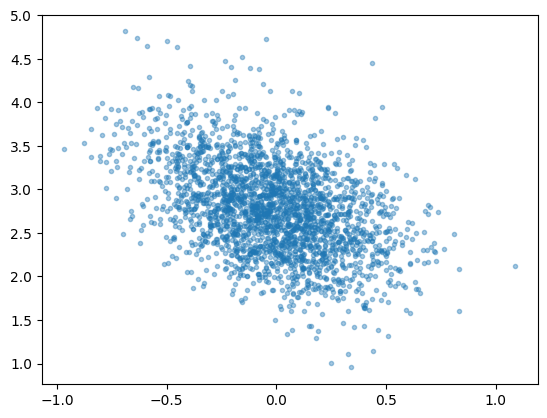

In [8]:
import matplotlib.pyplot as plt

# ode_targ = results_dict["aug_ode"][:, -1,:2]
sde_targ = results_dict["aug"][:, -1,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ[:, 0], sde_targ[:, 1], ".", alpha=0.4)

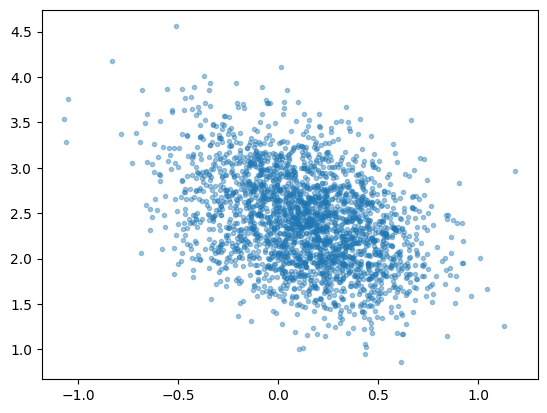

In [9]:
timestep = 90

sde_targ2 = results_dict["aug"][:, timestep,:2]

# plt.plot(ode_targ[:, 0], ode_targ[:, 1], ".", alpha=0.4)
plt.plot(sde_targ2[:, 0], sde_targ2[:, 1], ".", alpha=0.4)

In [10]:
jnp.array(results_dict["is_eval"]).mean()

DeviceArray(112.27593, dtype=float32)

In [11]:
results_dict["is_eval"]

[112.1129150390625,
 113.00736999511719,
 112.25170135498047,
 112.23796844482422,
 113.22325897216797,
 112.10995483398438,
 113.47113037109375,
 111.5778579711914,
 112.95504760742188,
 110.60472869873047,
 112.049560546875,
 113.1465072631836,
 111.62945556640625,
 112.76812744140625,
 111.6426010131836,
 112.36229705810547,
 113.05488586425781,
 111.87557220458984,
 111.92965698242188,
 112.79232788085938,
 113.15769958496094,
 111.77085876464844,
 112.41850280761719,
 111.9137954711914,
 113.21905517578125,
 111.57318878173828,
 110.76000213623047,
 111.91224670410156,
 112.31488800048828,
 112.43492126464844]

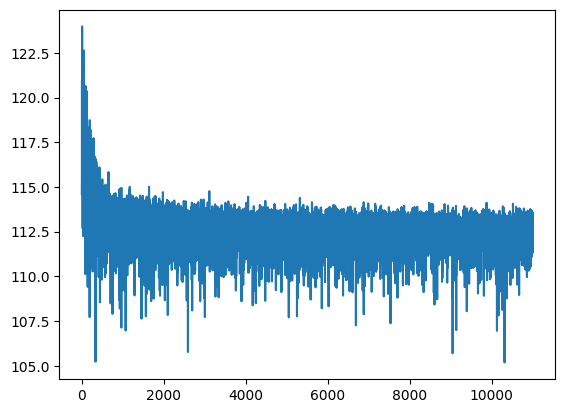

In [12]:
plt.plot(results_dict["is"])

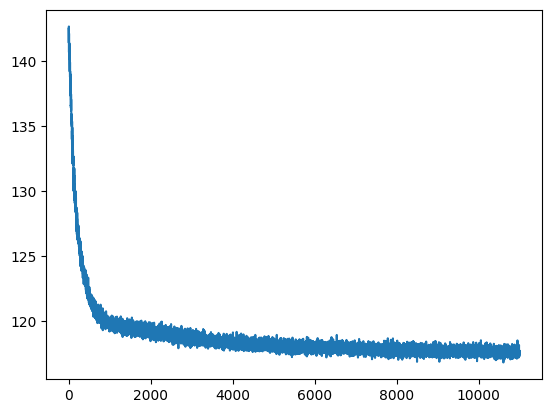

In [13]:
plt.plot(results_dict["elbo"])

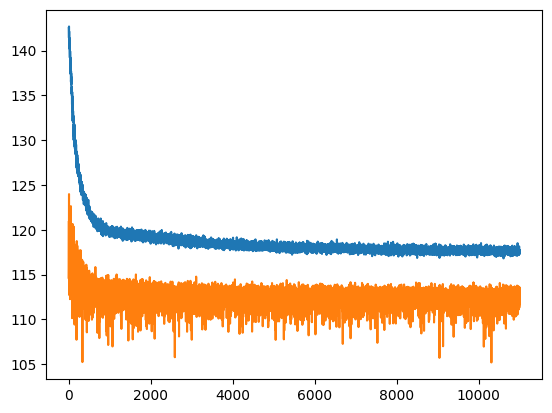

In [14]:
plt.plot(results_dict["elbo"])
plt.plot(results_dict["is"])

In [15]:
jnp.array(results_dict["elbo_eval"]).mean()

DeviceArray(117.61908, dtype=float32)